In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
from datetime import timezone
from dateutil.tz import *
import matplotlib.dates as mdates
from datetime import timedelta
import os
from model_utils import *
import matplotlib.dates as dates

#from iri2016 import timeprofile, timeprofile2

In [2]:
'''
;  PURPOSE:
;    The VDRIFT_MODEL procedure is the main routine for obtaining vertical drifts. The vertical drifts
;    dependences of the local time and longitudinal (See details in Scherlies and Fejer, 1999). 
;  INPUTS:
;    DOY = A scalar of integer type giving the Day of year. (e.g. doy = 347)
;    HOUR = Set this keyword to an integer  from 00 to 23 to define the hour (00... 24hrs). By default 
;      hour =12.
;    F107CM = A scalar giving the solar flux F10.7cm. By default it will take 150.
;    LONGITUDE = Geographic Longitude.    
;  OUTPUTS:
;    vdrift= vertical drifts
'''

def drift_model(year, doy,longitude):
    if doy == 0:
        doy = 161
    if longitude ==0:
        longitude = 270.0
    #constant = longitude
    start = 7.5
    finish = 16.5
    nsteps = 54
    step = int(finish-start)/nsteps
    ###############################################################
    #st = 0.0
    end = finish
    nsteps = step
    a = np.linspace(start,end,nsteps, endpoint=False)
    minutos = []
    horas = []
    for t in a:
        hour, minute = divmod(t, 1)
        minute *= 60
        result = '{}:{}'.format(int(hour), int(minute))
        #print(result)
        horas.append(int(hour))
        minutos.append(int(minute))
    ###################
    #year = 2020
    d = datetime.datetime.strptime('{} {}'.format(doy, year),'%j %Y')
    ###################
    m = np.zeros(nsteps)
    steps = np.zeros(nsteps)
    #FOR i=start,(finish*(1+(profil EQ 0))) DO steps[i]=i*step
    j=0
    f107_list = []#getIndexF107(year, doy, hour)
    datetime_list = []
    for i in np.linspace(start,finish,nsteps,endpoint=False):
        steps[j]=i*step
        temp = i#start + i*step
        steps[j] = temp
        str_time = '%d-%02d-%02d %02d:%02d:%02d' % (year, d.month, d.day,horas[j], minutos[j],0)
        dt = datetime.datetime.strptime(str_time, '%Y-%m-%d %H:%M:%S')
        datetime_list.append(dt)
        #print('i:', int(i))
        f107_list.append(getIndexF107(year, doy, int(i)))
        j = j + 1
    time = steps
    yv = []
    #Calling VDrifts to compute vertical drifts.
    for ii in range(0,(nsteps-1) + 1):
        xt=time[ii]
        xl=longitude
        y=vdrift(xt,xl,doy,f107_list[ii])
        yv.append(y)
    return yv,datetime_list

In [3]:
def GetMatrix_old(directory, filename, PlotFlag, plot_format):
    ##########################################################
    ## 2020-06-16: Se verificó que la función trabaja
    ## correctamente. Se creara una nueva para hacer pruebas 
    ## con las dimensiones
    ##########################################################
    file_hf5 = directory + filename
    hf = h5py.File(file_hf5, 'r')
    #with h5py.File(file_hf5, 'r') as f:
    #    g = f.visit(print)
    days = np.array(hf['Data/Table Layout/']['day'],dtype=int)
    year = np.array(hf['Data/Table Layout/']['year'],dtype=int)
    month = np.array(hf['Data/Table Layout/']['month'],dtype=int)
    hour = np.array(hf['Data/Table Layout/']['hour'],dtype=int)
    minutes = np.array( hf['Data/Table Layout/']['min'],dtype=int)
    seconds = np.array(hf['Data/Table Layout/']['sec'],dtype=int)
    rango = hf['Data/Table Layout/']['gdalt']
    rango2D = hf['Data/Array Layout/']['range']
    #Data/Array Layout/timestamps
    timestamps = hf['Data/Array Layout/']['timestamps']
    snl =  hf['Data/Table Layout/']['snl']
    snl2 = hf['Data/Array Layout/2D Parameters/snl']
      
    vipe1 = hf['Data/Array Layout/2D Parameters/vipe1'] 
    vipn1 = hf['Data/Array Layout/2D Parameters/vipn1']
    v_zonal = np.array(vipe1)
    v_vertical = np.array(vipn1)
    snl2 = np.array(snl2)
    time_vector = []
    date_list = [] # list for datetime objects
    datetimeFormat = '%Y-%m-%d %H:%M:%S'
    for y, m, d,h, mmins, sec in zip(year,month,days,hour,minutes,seconds):
        date_string = '%d-%02d-%02d %02d:%02d:%02d' % (y,m,d,h,mmins,sec)
        date = datetime.datetime(y,m,d,h,mmins, sec)#, datetimeFormat)
        time_vector.append(date_string)
        date_list.append(date)
    #####################################################################
    index = pd.DatetimeIndex(date_list) - timedelta(hours=5)
     ##########################################################
    # Aquí viene la conversión a listas 
    #converted_value = getattr(value, "tolist", lambda: value)()
    days = getattr(days, "tolist", lambda: days)()
    year = getattr(year, "tolist", lambda: year)()
    month = getattr(month, "tolist", lambda: month)()
    hour = getattr(hour, "tolist", lambda: hour)()
    minutes = getattr(minutes, "tolist", lambda: minutes)()
    seconds = getattr(seconds, "tolist", lambda: seconds)()
    rango = getattr(rango, "tolist", lambda: rango)()
    ###########################################################
    ran_max = max(rango)
    ran_min = min(rango)
    #rang_list = list(rango)
    max_index = rango.index(ran_max)
    min_index = rango.index(ran_min)
    range_diff = np.diff(rango)
    delta_range = range_diff[0] #valor constante para todo el arreglo
    MinRange, MaxRange = np.min(rango), ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    DataMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    RowInMatrix = np.array((rango-MinRange)/delta_range, dtype=int)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    #DataMatrix_v_zonal = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    #DataMatrix_v_vertical = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    
    string_date = index[0].strftime('%B %d, %Y, %r')
    #line.split()[0]
    #mes = string_date.split()[0]
    month_prime = index[0].month
    #if mes == 'June':
    #    mes ='Junio'
    #if mes == 'July':
    #    mes = 'Julio'
    #if mes == 'August':
    #    mes ='Agosto'
    mes = GetMonth(month_prime)
    dia = index[0].day
    anio = index[0].year
    
    dir_plots = 'Plots-150km-%s-%d' % (mes, anio)
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    #print("range(rango.size) ",range(rango.size))
    for k in range(len(rango)):
        row = RowInMatrix[k] 
    # Putting snr in corresponding matrix element
        DataMatrix[row,col] = snl[k]
        if row<PastRow:
            col += 1
        PastRow = row
    data = DataMatrix#[::-1]
    
    #######################################################################################################
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.rcParams['xtick.labelsize']=14
        
        #plt.style.use('dark_background')
        x_min = mdates.date2num(np.min(index))
        x_max = mdates.date2num(np.max(index))
        extent=[x_min, x_max,ran_min,ran_max]
        im2 = plt.imshow(data, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb2 = fig.colorbar(im2)
        cb2.set_label(r'$log_{10}SNR$', fontsize=17)
        #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)
    #####################################################################################
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.rcParams['xtick.labelsize']=14
        #plt.style.use('dark_background')
        im3 = plt.imshow(v_vertical.T, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)

        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb3 = fig.colorbar(im3)
        cb3.set_label(r'Velocidad vertical (m/s)', fontsize=15)
        #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-v-vertical.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)   
    #####################################################################################
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.style.use('dark_background')
        #plt.rcParams['xtick.labelsize']=14
        im4 = plt.imshow(v_zonal.T, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb4 = fig.colorbar(im4)
        cb4.set_label(r'Velocidad zonal (m/s)', fontsize=15)
        cb4.mappable.set_clim(-20,20)

        #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-v-zonal.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)   
    
    return  data ,snl, index, range_array, rango, dir_plots, time_vector, v_zonal, v_vertical, rango2D, timestamps, snl2

In [4]:
def AddNaN(a,b):
    result = np.add(a,b)

    a_is_nan = np.isnan(a)
    b_is_nan = np.isnan(b)

    result_is_nan = np.isnan(result)

    mask_a = np.logical_and(result_is_nan, np.logical_not(a_is_nan))
    result[mask_a] = a[mask_a]

    mask_b = np.logical_and(result_is_nan, np.logical_not(b_is_nan))
    result[mask_b] = b[mask_b]

    return result


In [5]:
def Diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))
    

In [6]:
def GetBinaryMatrix(d_prima):
    d_prima = d_prom.copy()
#d_prima[d_prima==np.nan]=0
#d_prima[d_prima!=np.nan]=1
    fils, cols = d_prima.shape
    matCount = np.zeros(d_prima.shape)
    for i in range(fils):
        for j in range(cols):
            if np.isnan(d_prima[i,j]):
                d_prima[i,j]=0
            #matCount[i,j]+=1
            else:
                d_prima[i,j]=1
                matCount[i,j]+=1
    return d_prima, matCount

In [7]:
def GetTimeRangeArrays(year, month, day, hour_i, hour_f, h_min, h_max, delta_ran):
    range_fixed = np.arange(h_min,h_max,delta_ran)
    string_t0 = '%d-%02d-%02d %02d:00:00' % (year, month, day, hour_i)
    string_tf = '%d-%02d-%02d %02d:00:00' % (year, month, day, hour_f)
    dt0 = datetime.datetime.strptime(string_t0, '%Y-%m-%d %H:%M:%S')
    dtf = datetime.datetime.strptime(string_tf, '%Y-%m-%d %H:%M:%S')# + timedelta(days=1)
#ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
    time_range = np.arange(dt0,dtf,timedelta(seconds=600))
    #print(time_range[1]-time_range[0])
    #print("time_range.shape: ", time_range.shape)
    #print("Type: ", type(time_range[0]))
    time_range = np.array(time_range).astype(datetime.datetime)#,dtype='datetime64[s]')
    return time_range, range_fixed

In [8]:
year = 202
month = 2
str_month = GetMonth(month)
day = 4
current_month = '%s-%d' % (str_month, year)
directory = 'Data-%s/' % current_month
str_format = 'png'
plot_format = str_format
filename1 ='jul%d%02d%02d_150km.001.hdf5' % (year,month,day)
plt.rcParams['ytick.labelsize']=15
plt.rcParams['xtick.labelsize']=15


In [9]:
file_hf5 = directory + filename1
hf = h5py.File(file_hf5, 'r')

with h5py.File(file_hf5, 'r') as f:
    g = f.visit(print)

OSError: Unable to open file (unable to open file: name = 'Data-Febrero-202/jul2020204_150km.001.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [10]:
def GetMatrix(directory, filename, PlotFlag, plot_format):
    hour_f= 19.0
    hour_i = 7.0
    h_min = 130#90.0
    h_max = 190#1008.75
    delta_ran = 1.5
    file_hf5 = directory + filename
    hf = h5py.File(file_hf5, 'r')
    #with h5py.File(file_hf5, 'r') as f:
    #    g = f.visit(print)
    rango = hf['Data/Table Layout/']['gdalt']
    rango2D = hf['Data/Array Layout/']['range']
    timestamps = hf['Data/Array Layout/']['timestamps']
    snl =  hf['Data/Table Layout/']['snl']
    vvert = hf['Data/Table Layout/']['vipn1']
    snl2 = hf['Data/Array Layout/2D Parameters/snl']
    vipe1 = hf['Data/Array Layout/2D Parameters/vipe1'] 
    vipn1 = hf['Data/Array Layout/2D Parameters/vipn1']
    v_zonal = np.array(vipe1)
    v_vertical = np.array(vipn1)
    snl2 = np.array(snl2)
    time_vector = []
    date_list = [] # list for datetime objects
    datetimeFormat = '%Y-%m-%d %H:%M:%S'
    prev_stamps = []
    datetime_objects = []
    for ts in timestamps:
        if ts in prev_stamps:
            print('Same timestap')
        else:
            date_time_obj = datetime.datetime.fromtimestamp(ts)
            datetime_objects.append(date_time_obj)
    index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
    datetime_objects = np.array(datetime_objects)#,dtype='datetime64[s]')
    day = index[0].day
    anio = index[0].year
    month = index[0].month
    mes = GetMonth(month)
    time_range, range_fixed = GetTimeRangeArrays(year, month, day, hour_i, hour_f,h_min,h_max,delta_ran)
    ran_max = max(rango)
    ran_min = min(rango)
    range_diff = np.diff(rango)
    delta_range = range_diff[0] #valor constante para todo el arreglo
    MinRange, MaxRange = np.min(rango), ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    DataMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    RowInMatrix = np.array((np.array(rango)-MinRange)/delta_range, dtype=int)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    DriftMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    string_date = index[0].strftime('%B %d, %Y, %r')
    month_prime = index[0].month
    mes = GetMonth(month_prime)
    dia = index[0].day
    anio = index[0].year
    time_range, range_fixed = GetTimeRangeArrays(anio, month_prime, dia, hour_i, hour_f,h_min,h_max,delta_ran)

    dir_plots = 'Plots-150km-%s-%d' % (mes, anio)
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    for k in range(len(rango)):
        row = RowInMatrix[k] 
    #Filtering out on SNR and vertical drifts:
        if ((snl[k]>-3.0)): #and vvert[k]<=20):
    # Putting snr in corresponding matrix element
            DataMatrix[row,col] = snl[k]
            DriftMatrix[row,col] = vvert[k]
            #countMat[row,col]+=1
        else:
            DataMatrix[row,col] = np.nan
            DriftMatrix[row,col] = np.nan
        if row<PastRow:
            col += 1
        PastRow = row
    data = DataMatrix.T#[::-1]
    v_vert = DriftMatrix.T
 
    print("Dimensiones: ", datetime_objects.shape, range_array.shape, data.shape)
    print(time_range.shape, range_fixed.shape)
    ##########################################################################################
    ############################################################################################
    string_t0 = '%d-%02d-%02d %02d:00:00' % (year, month, day, 7)
    dt0 = datetime.datetime.strptime(string_t0, '%Y-%m-%d %H:%M:%S')
    dt_indices = np.array((datetime_objects-dt0)/timedelta(seconds=600),dtype=int)
    m = np.r_[True,dt_indices[:-1]!=dt_indices[1:],True]
    counts = np.diff(np.flatnonzero(m))
    unq = dt_indices[m[:-1]]
    times_repeated=np.c_[unq,counts] 
    time_range_index = np.arange(0,72)

    
    d_prom = np.zeros((times_repeated.shape[0], range_fixed.shape[0]))
    v_prom = np.zeros((times_repeated.shape[0], range_fixed.shape[0]))
    for j in range(data.shape[1]):
    
        for i in range(times_repeated.shape[0]):
            if i==0:
                d_prom[i,j] = np.nanmean(data[0:times_repeated[0,1],j])
                v_prom[i,j] = np.nanmean(v_vert[0:times_repeated[0,1],j])
            else:
                aux = np.sum(times_repeated[0:i,1])
                aux2 = times_repeated[i,1]
                d_prom[i,j] = np.nanmean(data[aux:aux+aux2,j])
                v_prom[i,j] = np.nanmean(v_vert[aux:aux+aux2,j])
    index_aux = times_repeated[:,0]
    diff = Diff(time_range_index, index_aux)
    diff=np.array(diff)
    diff=np.sort(diff)
    diff=diff.astype(np.dtype('int64'))
    
    b3=np.ones((time_range_index.shape[0],range_fixed.shape[0]))*np.nan
    v3 = np.ones((time_range_index.shape[0],range_fixed.shape[0]))*np.nan
    for j in range(data.shape[1]):
        b_aux=d_prom[:,j]
        v_aux=v_prom[:,j]
        for i in list(diff):
            aux=b_aux[:i]
            aux2=b_aux[i:]
            aux=np.append(aux,np.nan)
            aux=np.append(aux,b_aux[i:])
            b_aux=aux
            
            vaux=v_aux[:i]
            vaux2=v_aux[i:]
            vaux=np.append(vaux,np.nan)
            vaux=np.append(vaux,v_aux[i:])
            v_aux=vaux
            
        b3[:,j]=b_aux
        v3[:,j]=v_aux
    
    ##########################################################################################
    #######################################################################################################
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(12, 6))
        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, v3.T,cmap='jet')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([130,190])
        str_ti = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,8)
        str_tf = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,17)
        dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
        dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
        ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])

#dia = dia - 1
        '''
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (year, month, day) 
        plt.title(fig_title, fontsize=15)
        str_date = '(%d-%02d-%02d)' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)        
    #cb2 = fig.colorbar(im2)
        cb.set_label(r'$log_{10}SNR$', fontsize=17)
        #print(str_date)
        #plt.show()
        plt.savefig('promedio-%s.png' % (str_date))

        #plt.close(fig)
        fig, ax = plt.subplots(figsize=(12, 6))        
        clrs0 = ax.pcolormesh(datetime_objects,range_array,v_vertical.T, cmap='jet')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([130,190])
        str_ti = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,8)
        str_tf = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,17)
        dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
        dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
        ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])

        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb2 = fig.colorbar(clrs0)
        cb2.set_label(r'$log_{10}SNR$', fontsize=17)
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        plt.show()
        plt.close(fig)
    
    #####################################################################################
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.rcParams['xtick.labelsize']=14
        #plt.style.use('dark_background')
        clrs1 = ax.pcolormesh(datetime_objects,rango2D,v_vertical.T, cmap='jet')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        fig.autofmt_xdate()
        cb3 = fig.colorbar(clrs1)
        cb3.set_label(r'Velocidad vertical (m/s)', fontsize=15)
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-v-vertical.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        plt.show()
        plt.close(fig)   
    #####################################################################################
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.style.use('dark_background')
        clrs = ax.pcolormesh(datetime_objects,rango2D,v_zonal.T, cmap='jet')#,vmin=0,vmax=2e11)
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb4 = fig.colorbar(clrs)
        cb4.set_label(r'Velocidad zonal (m/s)', fontsize=15)
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-v-zonal.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        plt.show()
        plt.close(fig)   
        '''
    return  data, index, range_array,dir_plots,datetime_objects, b3, range_fixed, time_range,v_vertical,v3

In [11]:
datetime_str = '2021-03-01 13:55:26'
datetime_object = datetime.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')



Dimensiones:  (325,) (28,) (325, 28)
(72,) (40,)


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice
/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: Mean of empty slice
/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: Mean of empty slice
/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: Mean of empty slice


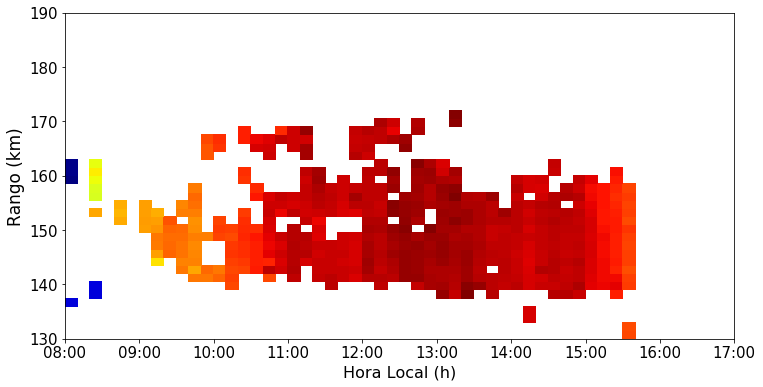

In [12]:
PlotFlag = True
data, index, range_array,dir_plots,datetime_objects, d_prom, range_fixed, time_range, v_vertical,v_prom = GetMatrix(directory, filename1, PlotFlag, 'png')
#directory, filename, PlotFlag, plot_format

jul20210404_150km.001.hdf5
Dimensiones:  (325,) (28,) (325, 28)
(72,) (40,)


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice
/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: Mean of empty slice
/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: Mean of empty slice
/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: Mean of empty slice


v_vertical.shape:  (325, 28) (72, 40)
jul20210401_150km.001.hdf5
Dimensiones:  (308,) (32,) (308, 32)
(72,) (40,)
v_vertical.shape:  (308, 32) (72, 40)
jul20210410_150km.001.hdf5
Dimensiones:  (348,) (33,) (348, 33)
(72,) (40,)
v_vertical.shape:  (348, 33) (72, 40)
jul20210413_150km.001.hdf5
Dimensiones:  (191,) (31,) (191, 31)
(72,) (40,)
v_vertical.shape:  (191, 28) (72, 40)
jul20210420_150km.001.hdf5
Dimensiones:  (235,) (31,) (235, 31)
(72,) (40,)
v_vertical.shape:  (235, 30) (72, 40)
jul20210418_150km.001.hdf5
Dimensiones:  (269,) (32,) (269, 32)
(72,) (40,)
v_vertical.shape:  (269, 28) (72, 40)
jul20210421_150km.001.hdf5
Dimensiones:  (307,) (27,) (307, 27)
(72,) (40,)
v_vertical.shape:  (307, 27) (72, 40)
jul20210417_150km.001.hdf5
Dimensiones:  (313,) (32,) (313, 32)
(72,) (40,)
v_vertical.shape:  (313, 30) (72, 40)
jul20210403_150km.001.hdf5
Dimensiones:  (320,) (32,) (320, 32)
(72,) (40,)
v_vertical.shape:  (320, 32) (72, 40)
jul20210402_150km.001.hdf5
Dimensiones:  (306,) (3

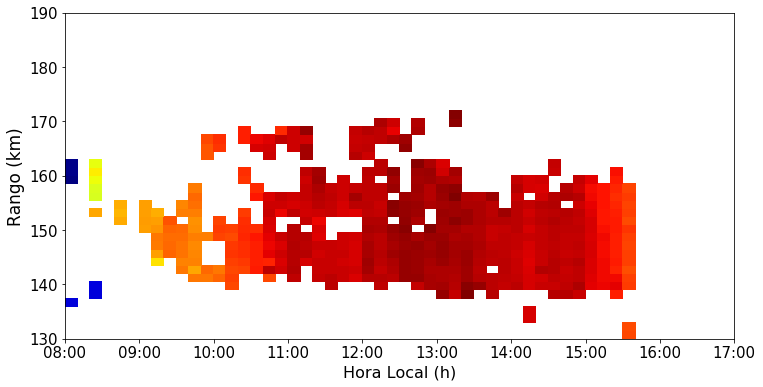

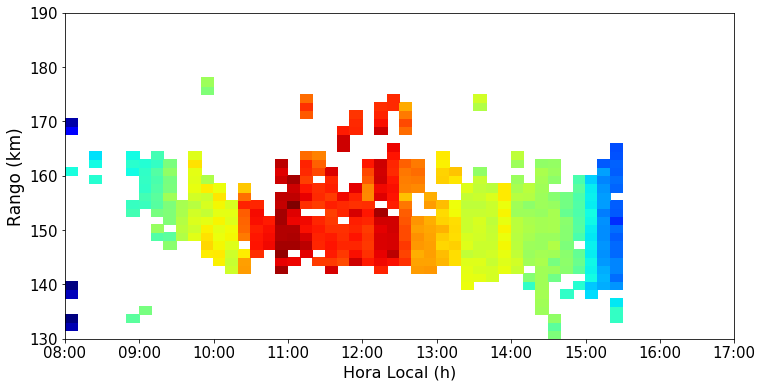

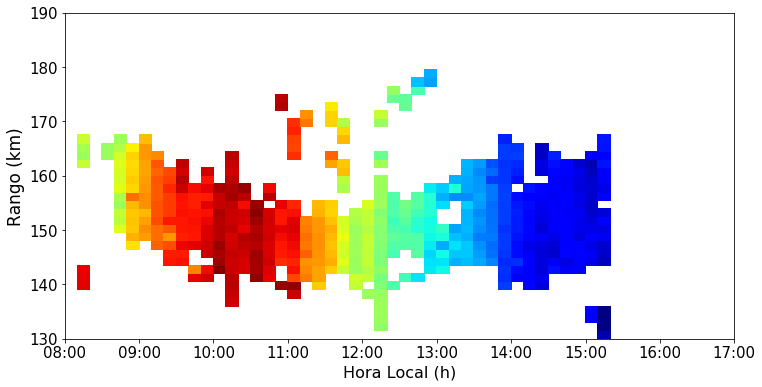

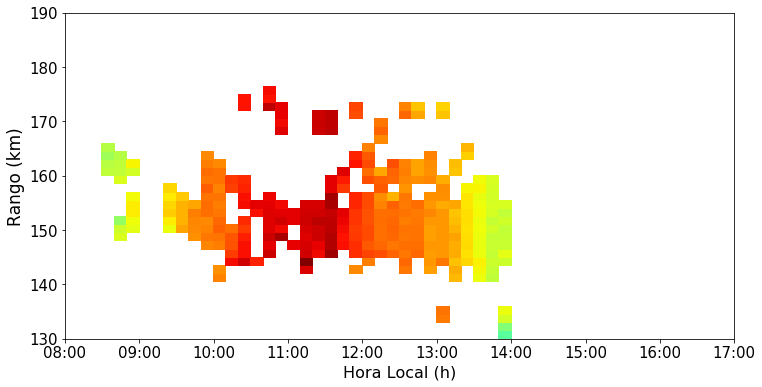

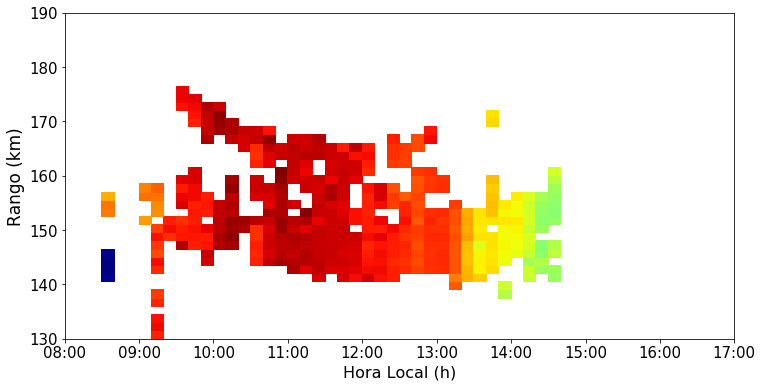

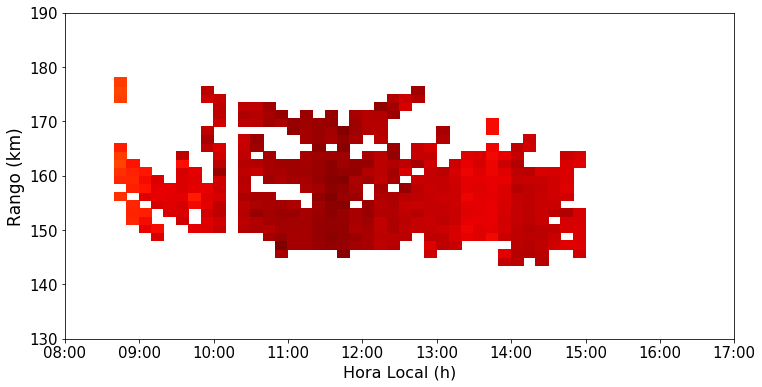

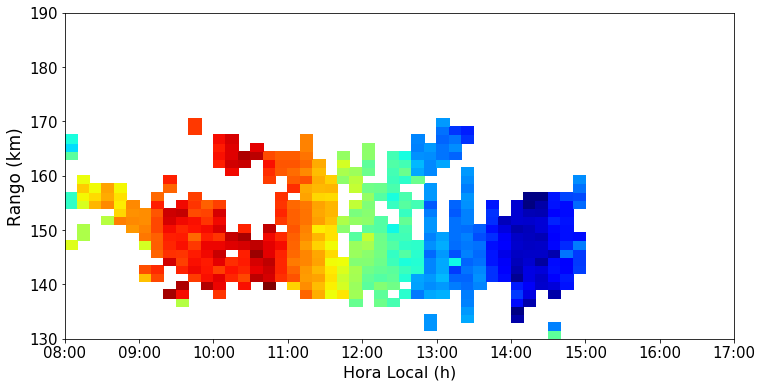

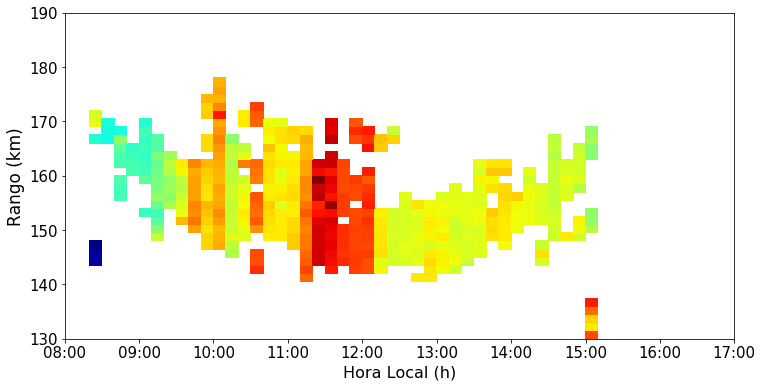

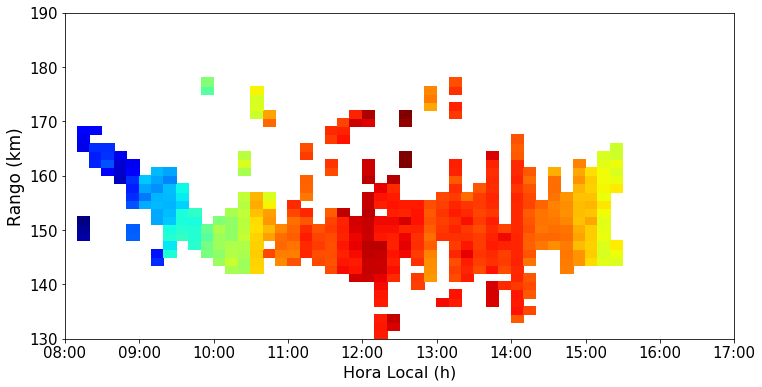

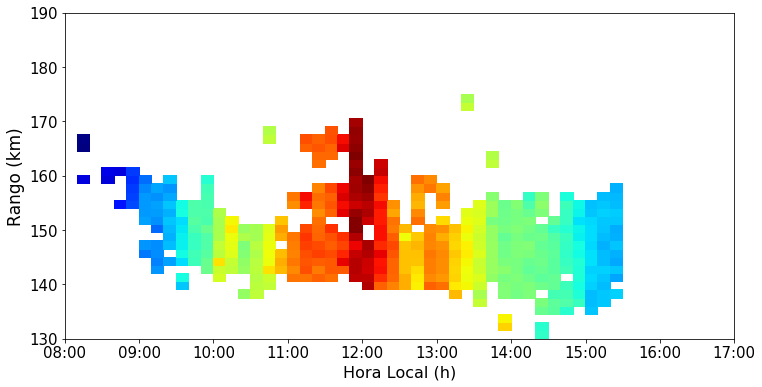

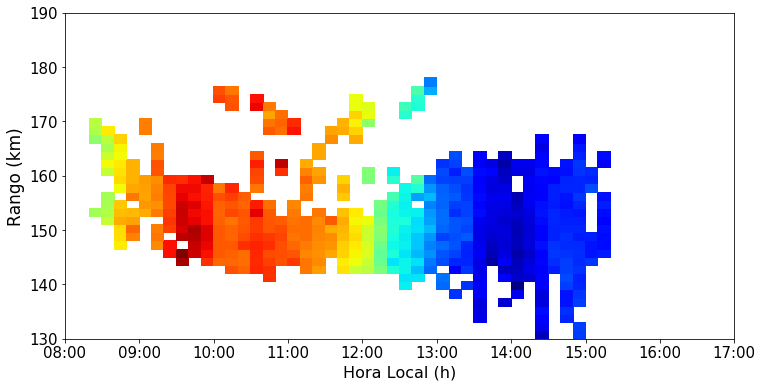

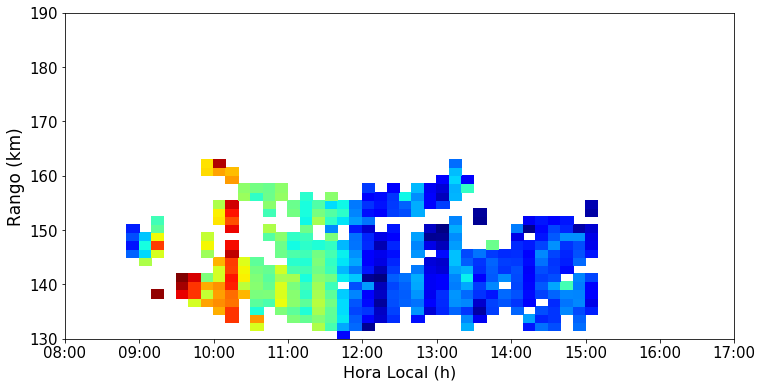

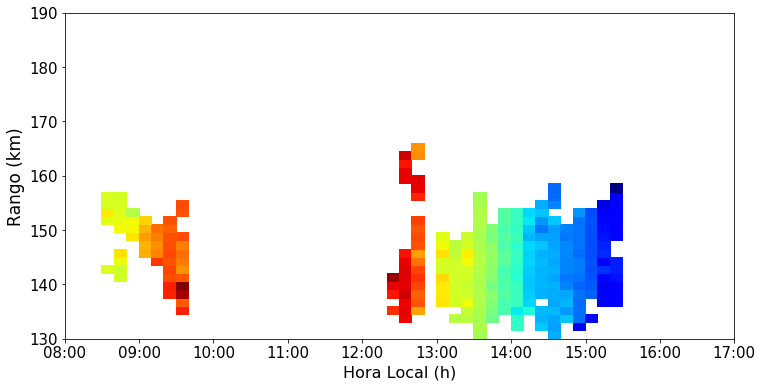

In [13]:
mat_avg = np.zeros((72, 40))
mat_drifts = np.zeros((72, 40))
counter = 0
#counter = np.zeros((78, 245))
PlotFlag = True
#plot_format= ''
array_list = []
for filename2 in os.listdir(directory):
    if filename2.endswith(".hdf5"):
        print('========================================================')
        print(filename2)
        #data , snl2, snl, index, range_array, rango, dir_plots, time_vector = GetMatrix(directory, filename2, PlotFlag)
        data, index, range_array,dir_plots,datetime_objects, d_prom, range_fixed, time_range,v_vertical, v_prom = GetMatrix(directory, filename2, PlotFlag, 'png')
        matBin, matCount = GetBinaryMatrix(d_prom)
        #print(d_prom.shape, data.shape)
        #aux = AddNaN(mat_drifts,v_prom)
        mat_drifts = AddNaN(mat_drifts,v_prom)
        mat_avg = mat_avg + matBin
        counter = counter + 1 #+ matCount
        print("v_vertical.shape: ",v_vertical.shape, v_prom.shape)
        #print(range_array[0], range_array[-1], index[0], index[-1])
        #print("datetime_objects: ", datetime_objects.shape,np.diff(datetime_objects)[0])
        #print(data.shape, len(snl), index.shape, range_array.shape, len(rango),np.diff(range_array)[0])
        #print('========================================================')
        #counter+=1

In [14]:
mat_avg_final=100*mat_avg/counter
mat_drifts = mat_drifts/counter

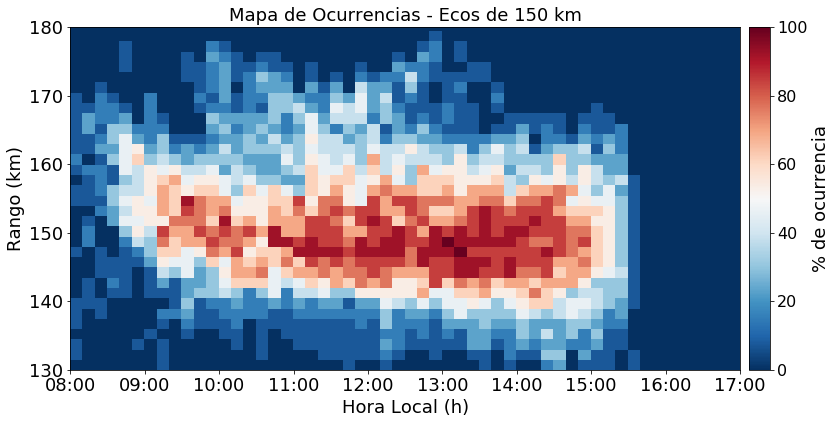

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
color_palette = 'RdBu_r'#'Reds'
clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, mat_avg_final.T,cmap=color_palette)#'RdBu_r')#'jet')

ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
'''
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')
'''
#ax.tick_params(axis='x', rotation=0)
#ax.tick_params(axis='y', rotation=0)
ax.set_xlabel("Hora Local (h)", fontsize=18)
ax.set_ylabel("Rango (km)", fontsize=18)
ax.set_ylim([130,180])
#dia = dia - 1
#ax.xticks(fontsize=14, rotation=90)

str_ti = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,8)
str_tf = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,17)
dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])
fig_title = r'Mapa de Ocurrencias - Ecos de 150 km' #% (year, month, day) 
plt.title(fig_title, fontsize=18)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.mappable.set_clim(0,100)
    #cb2 = fig.colorbar(im2)
cb.set_label(r'% de ocurrencia', fontsize=18)
cb.ax.tick_params(labelsize=16)
str_fig = 'mapa-de-ocurrencias-Ecos-de-150km%d-%s-%s.%s' % (year, GetMonth(month),color_palette,plot_format)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )
plt.savefig(str_fig,bbox_inches="tight")

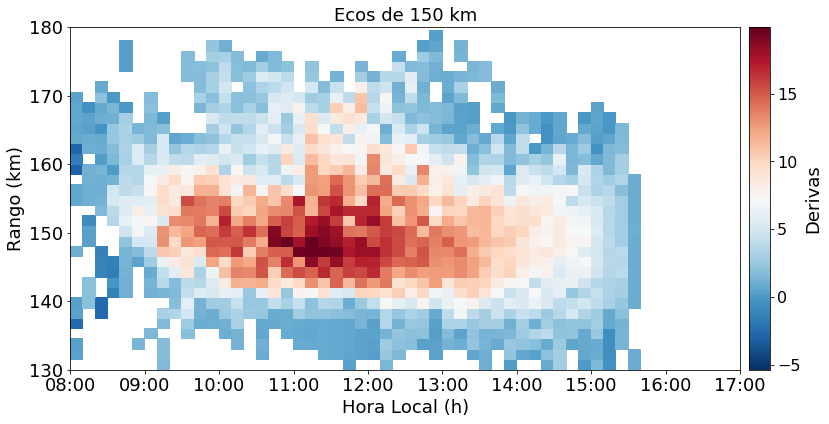

In [16]:
mat_drifts[mat_drifts==0]=np.nan
fig, ax = plt.subplots(figsize=(12, 7))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
color_palette = 'RdBu_r'#'Reds'#'jet'
clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, mat_drifts.T,cmap=color_palette)#'RdBu_r')#'jet')

ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
#ax.tick_params(axis='x', rotation=0)
#ax.tick_params(axis='y', rotation=0)
ax.set_xlabel("Hora Local (h)", fontsize=18)
ax.set_ylabel("Rango (km)", fontsize=18)
ax.set_ylim([130,180])
#str_ti = '2021-03-31 07:00:00'
#str_tf = '2021-03-31 17:00:00'
#dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
#dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
#ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])

#dia = dia - 1
#ax.xticks(fontsize=14, rotation=90)


str_ti = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,8)
str_tf = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,17)
dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])
fig_title = r'Ecos de 150 km' #% (year, month, day) 
plt.title(fig_title, fontsize=18)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
#cb.mappable.set_clim(0,100)
    #cb2 = fig.colorbar(im2)
cb.set_label(r'Derivas', fontsize=18)
cb.ax.tick_params(labelsize=16)
str_fig = 'rti-promedio-ecos-150km-%d-%s-nuevo-%s' % (year, GetMonth(month),color_palette)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )

plt.savefig(str_fig)

In [17]:
print(mat_avg_final[mat_avg_final>100])
print(time_range[0])


[]
2021-04-12 07:00:00


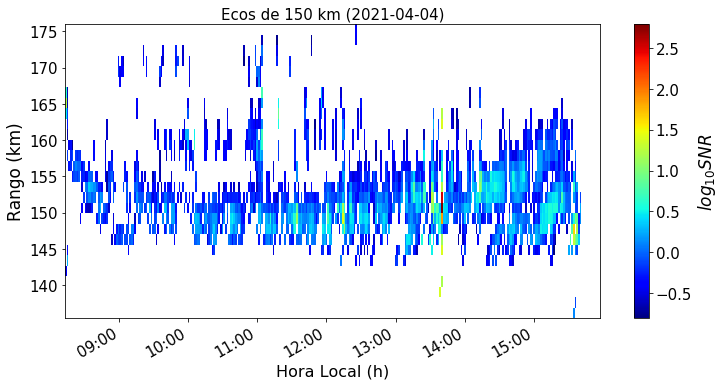

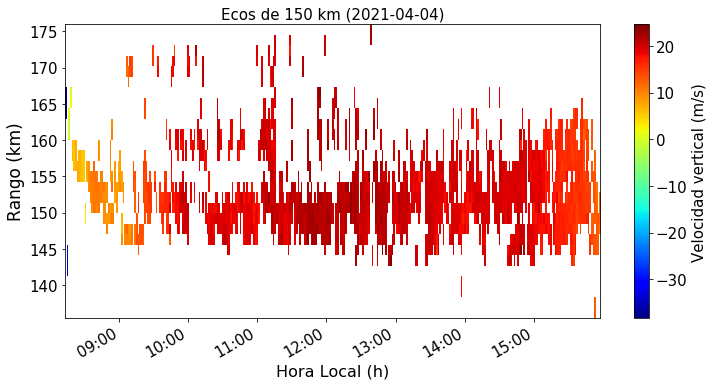

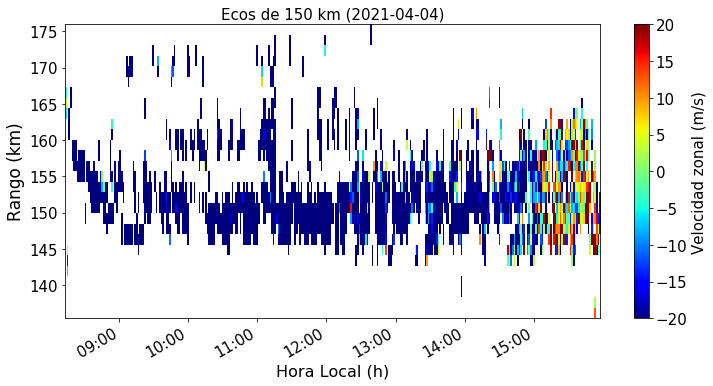

(28, 325) 2021-04-04 08:12:28 2021-04-04 15:58:03 0.0 135.45 175.95 1.5


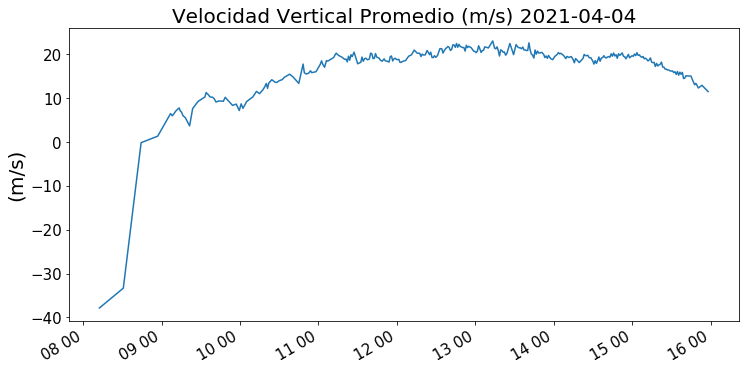

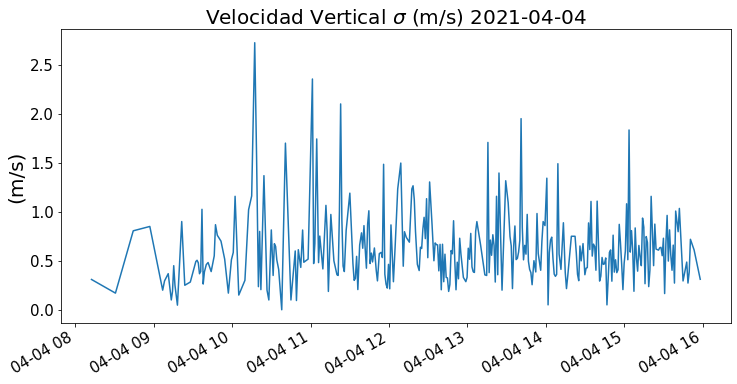

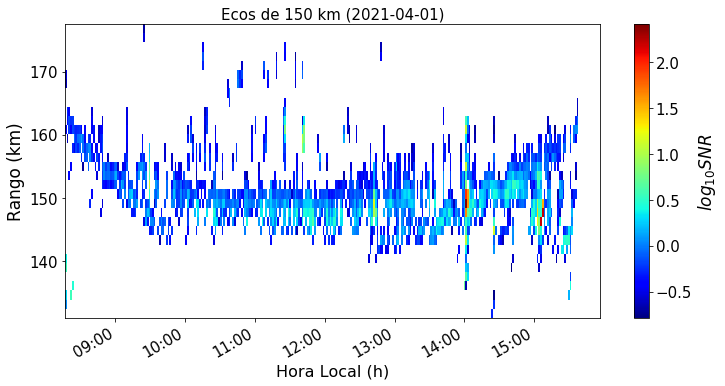

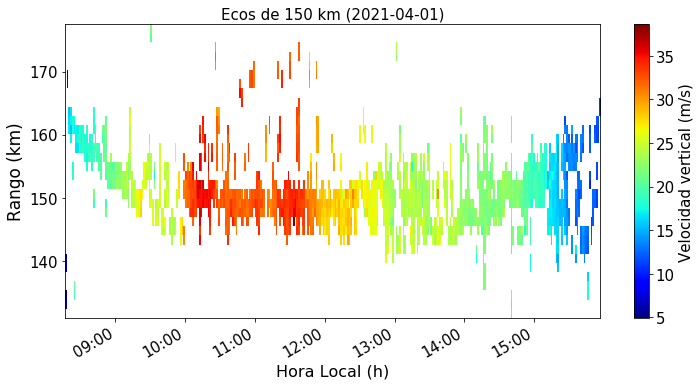

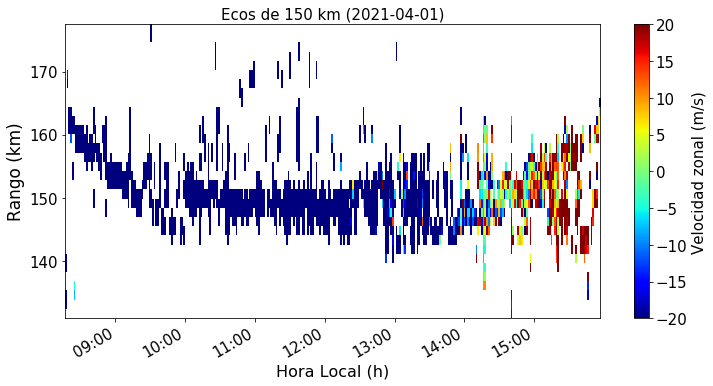

(32, 308) 2021-04-01 08:16:28 2021-04-01 15:56:54 0.0 130.95 177.45 1.5


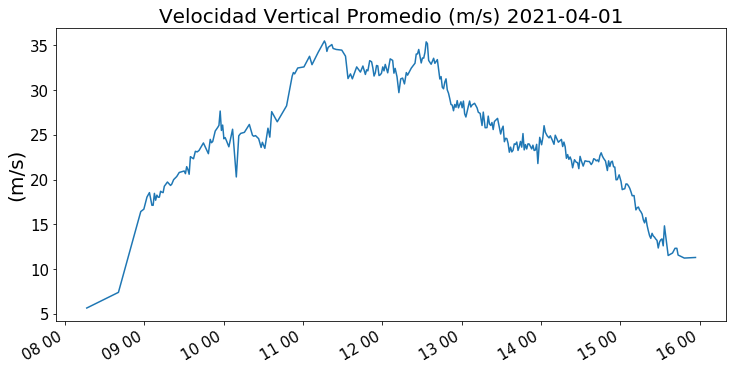

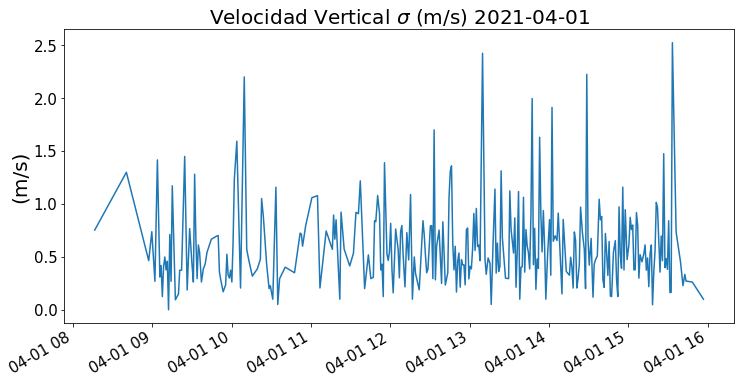

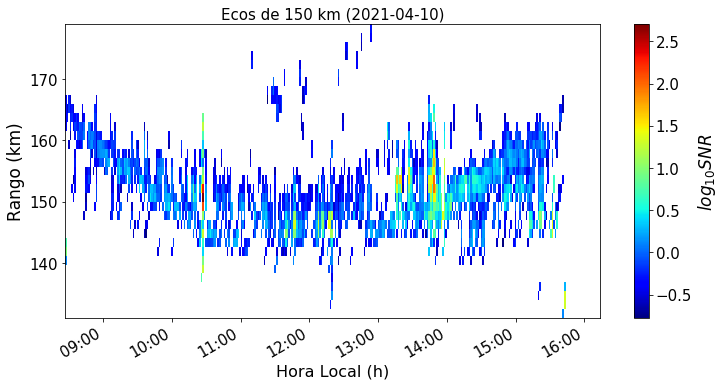

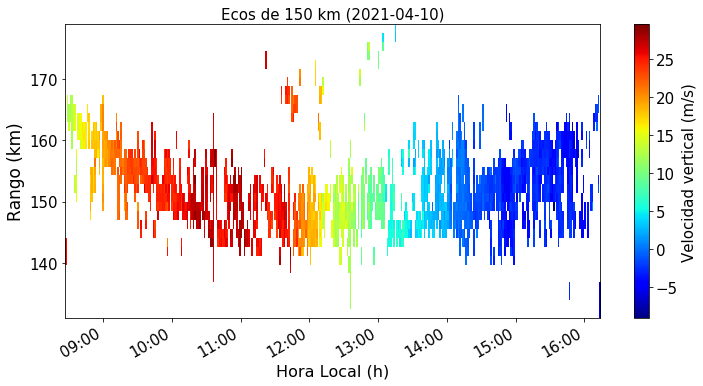

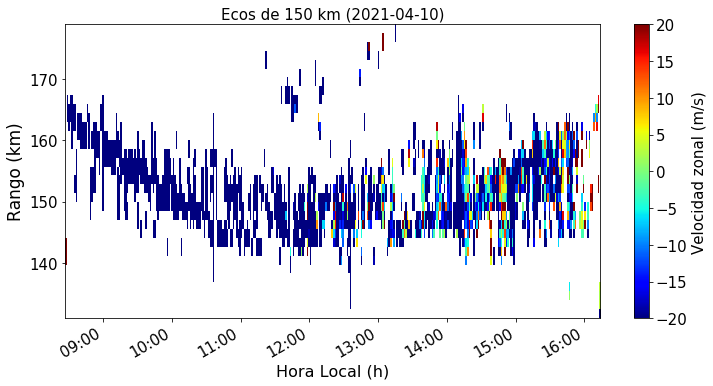

(33, 348) 2021-04-10 08:26:34 2021-04-10 16:14:01 0.0 130.95 178.95 1.5


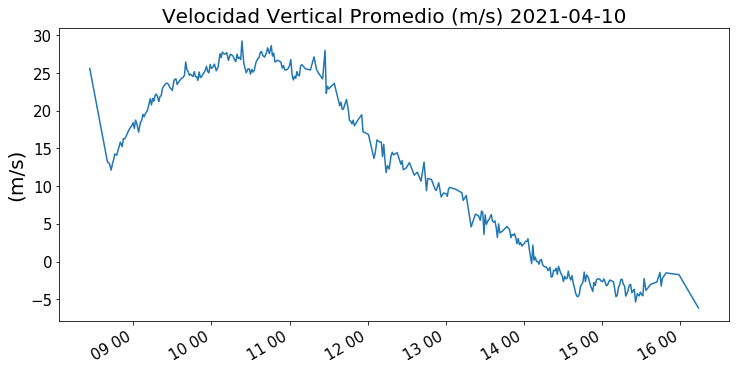

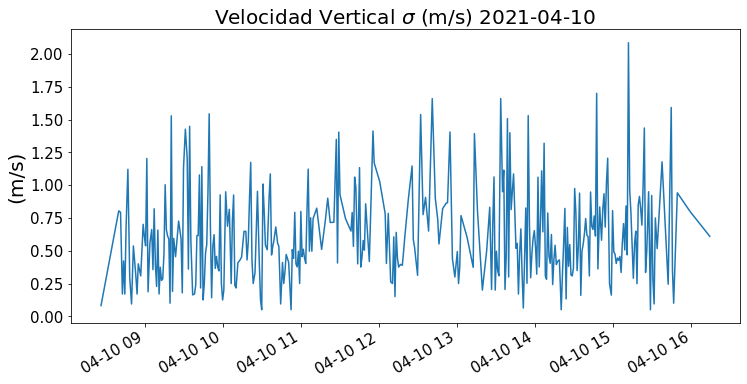

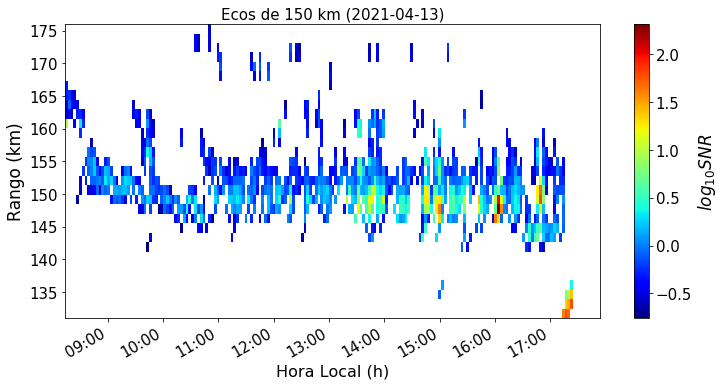

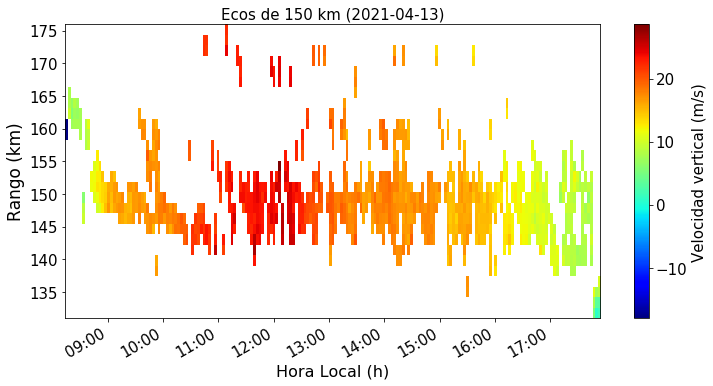

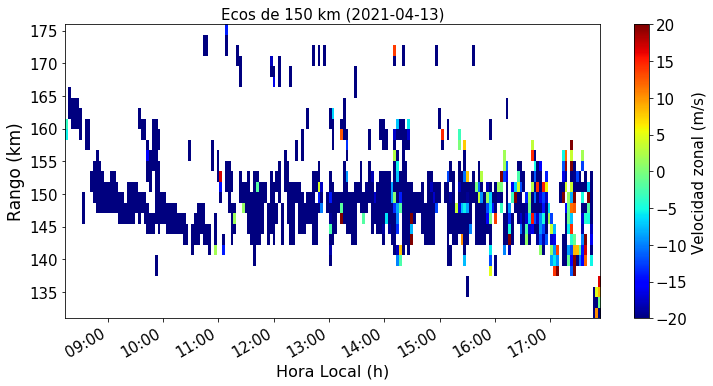

(31, 191) 2021-04-13 08:13:10 2021-04-13 17:54:15 0.0 130.95 175.95 1.5


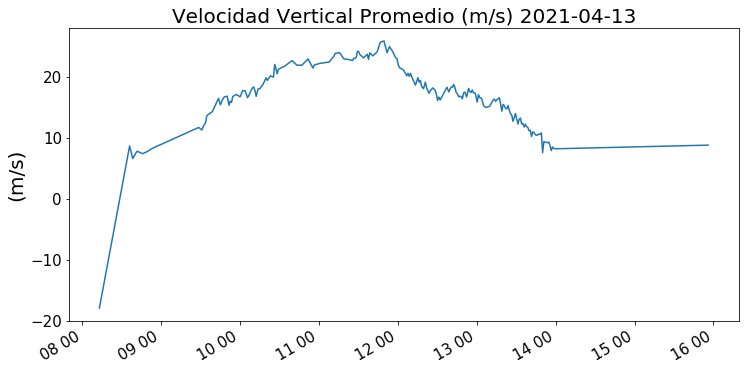

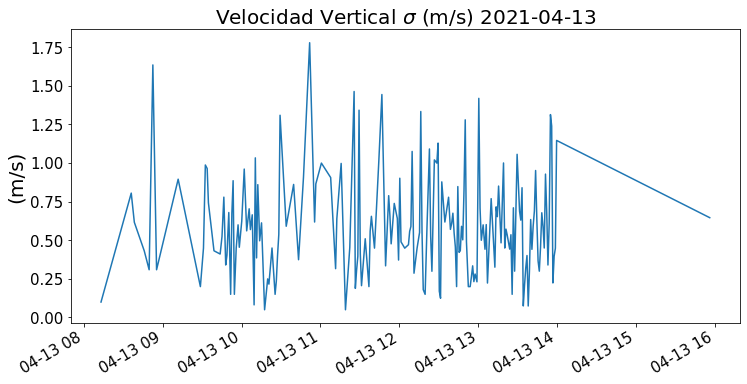

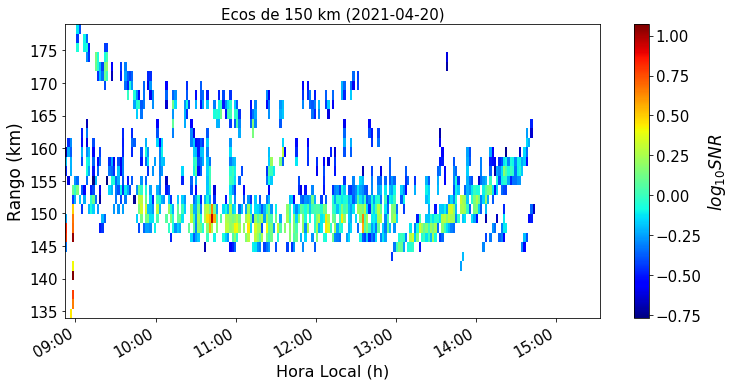

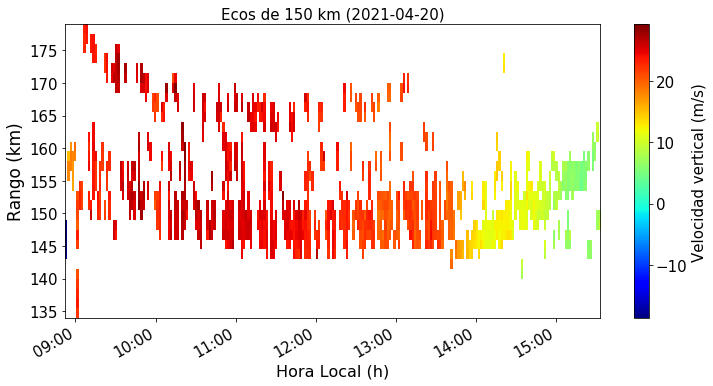

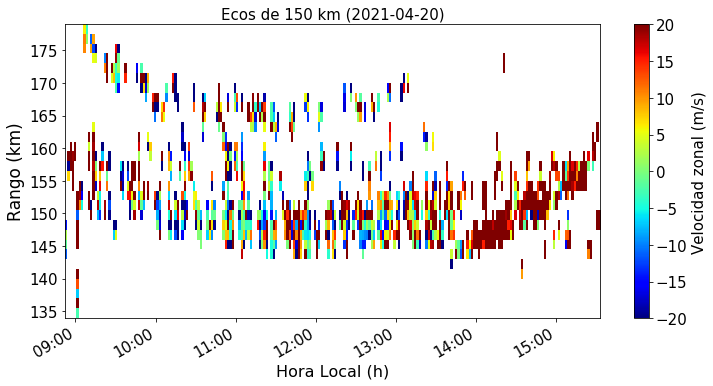

(31, 235) 2021-04-20 08:51:55 2021-04-20 15:33:11 0.0 133.95 178.95 1.5


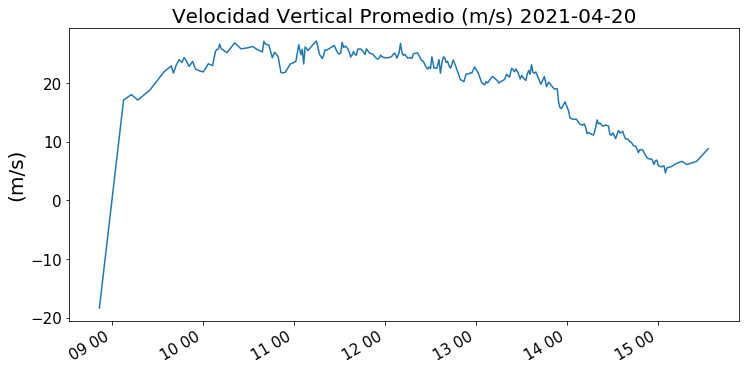

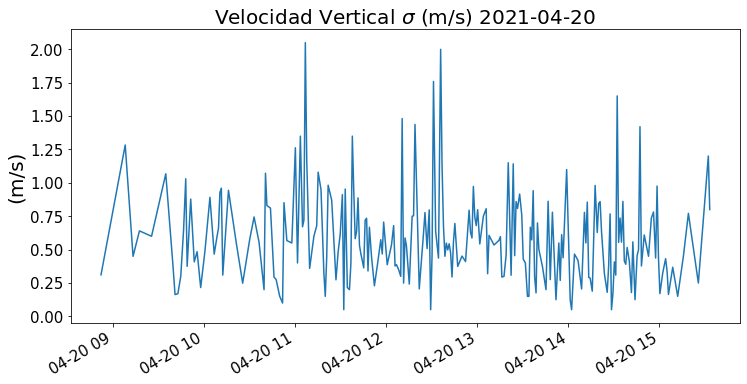

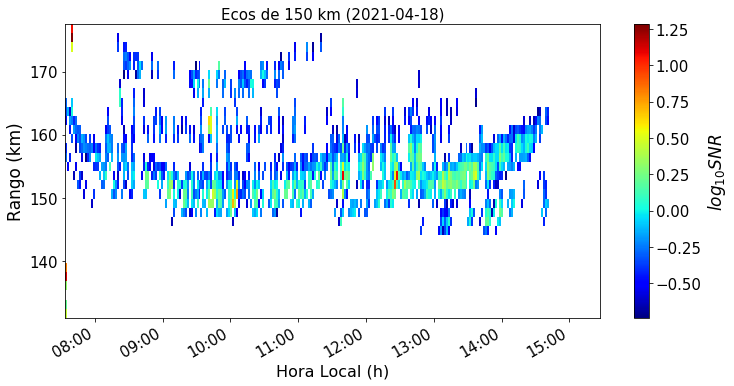

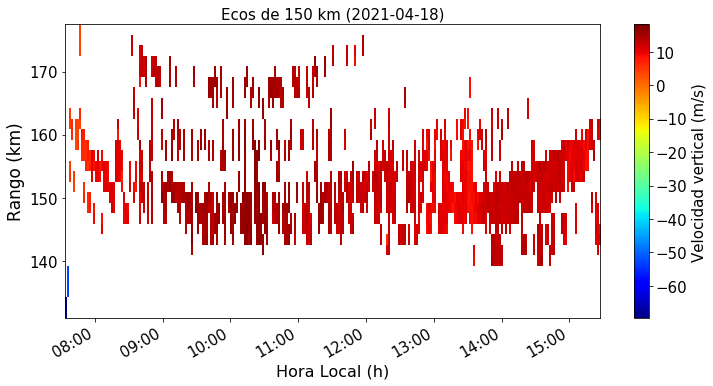

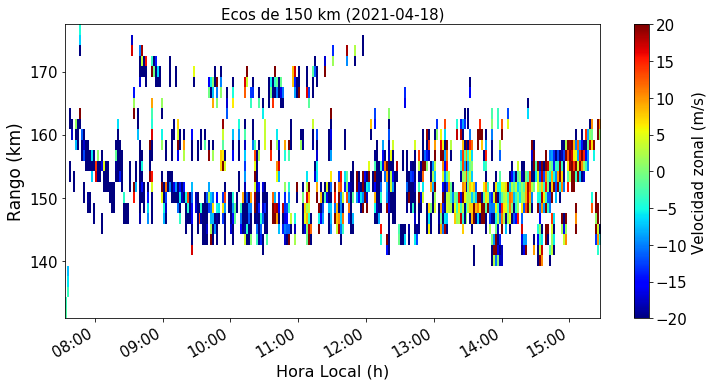

(32, 269) 2021-04-18 07:33:19 2021-04-18 15:27:22 0.0 130.95 177.45 1.5


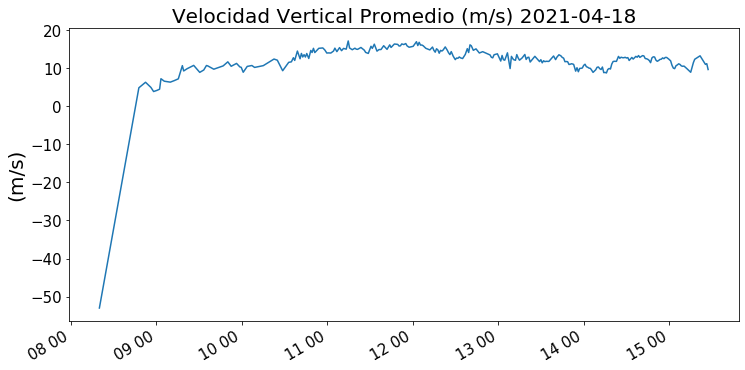

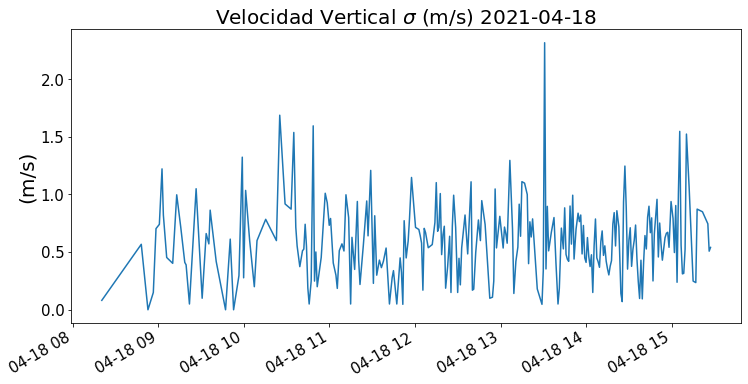

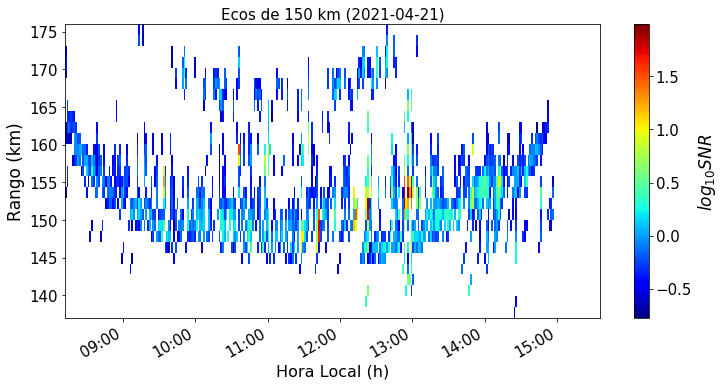

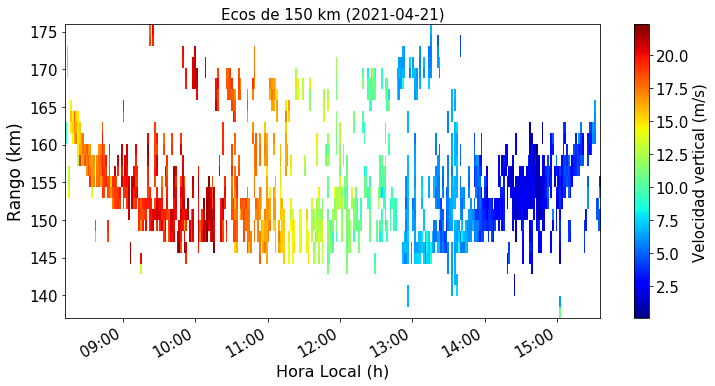

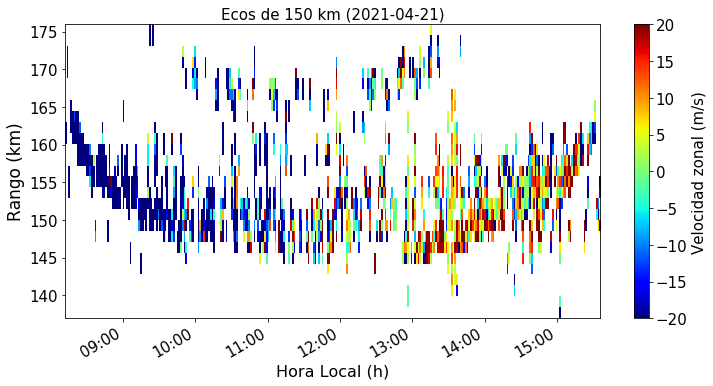

(27, 307) 2021-04-21 08:11:40 2021-04-21 15:36:06 0.0 136.95 175.95 1.5


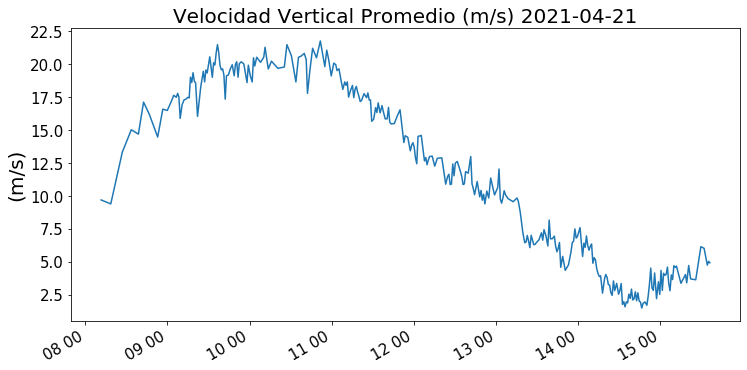

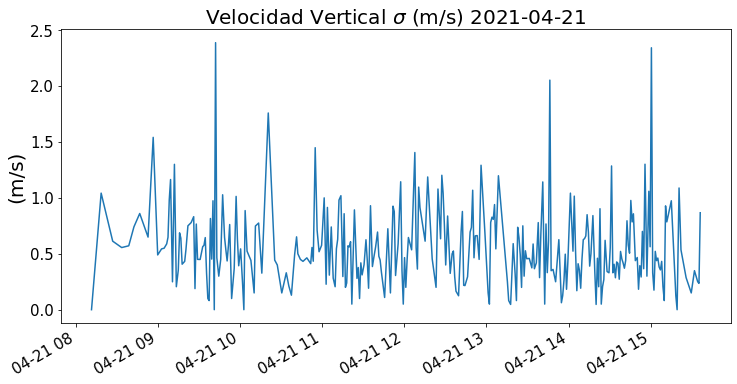

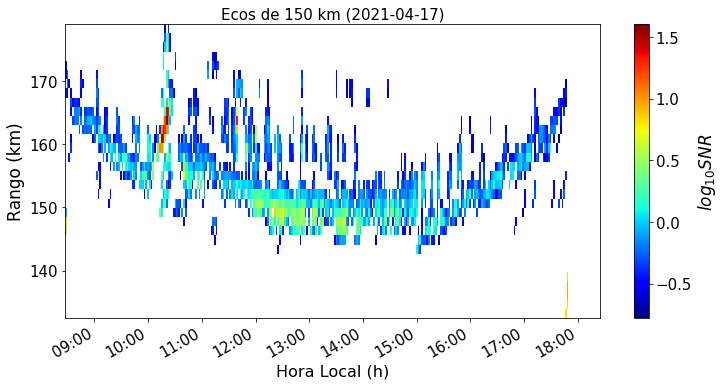

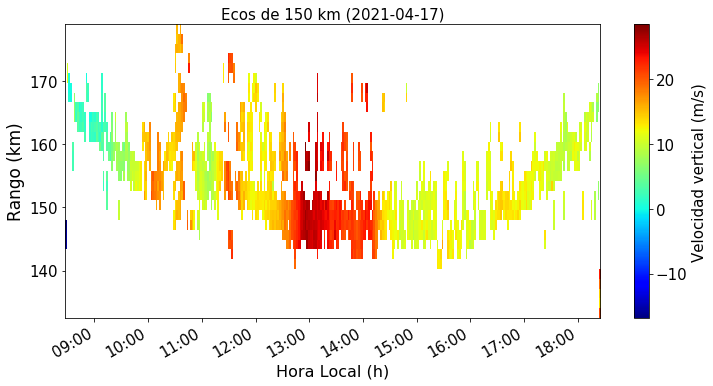

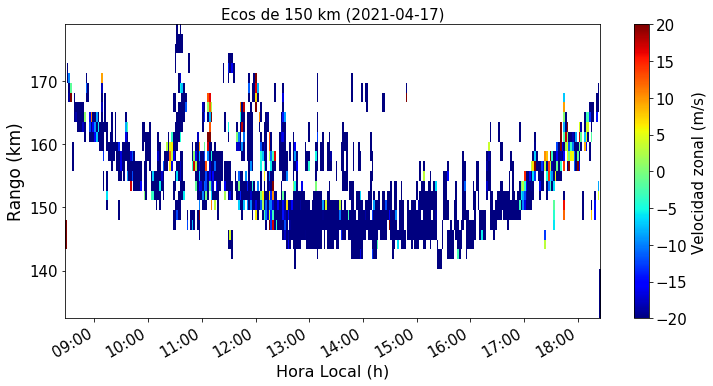

(32, 313) 2021-04-17 08:26:47 2021-04-17 18:25:13 0.0 132.45 178.95 1.5


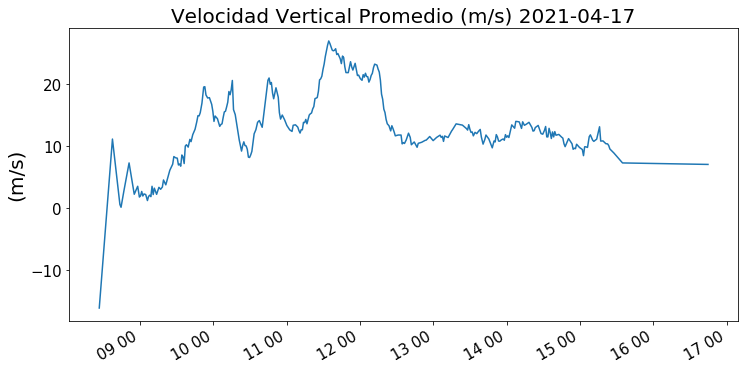

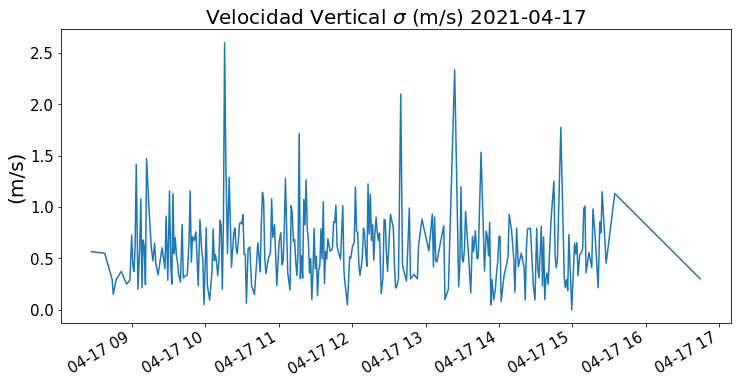

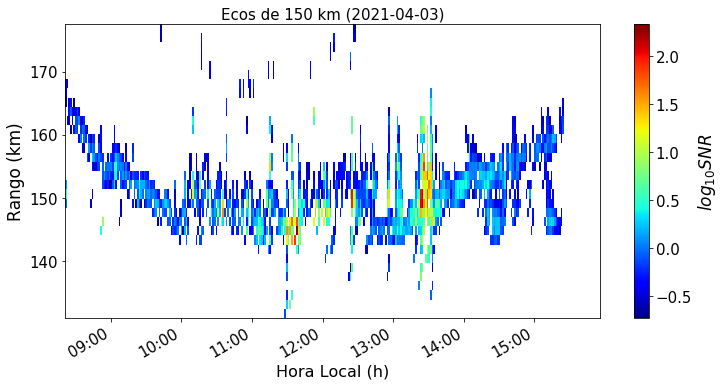

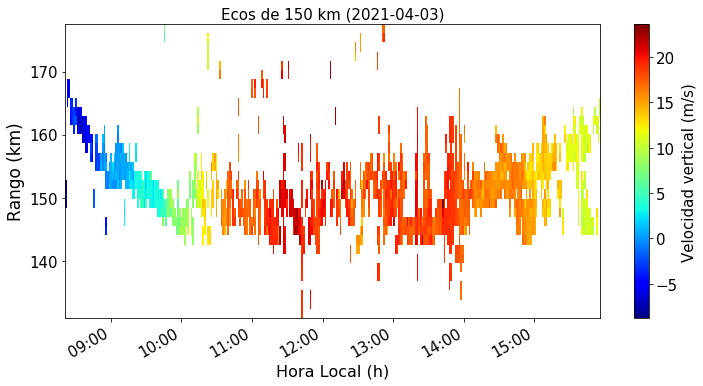

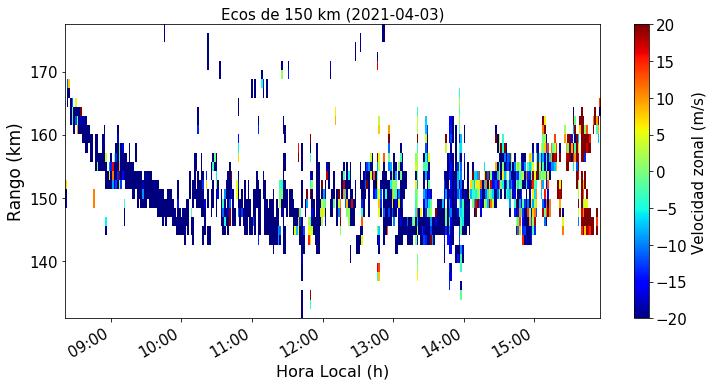

(32, 320) 2021-04-03 08:20:51 2021-04-03 15:56:06 0.0 130.95 177.45 1.5


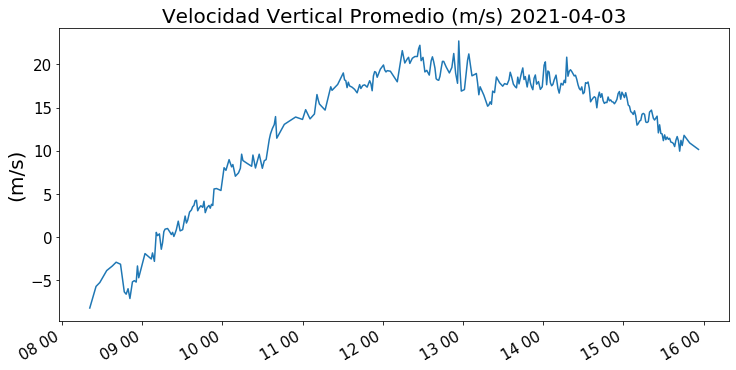

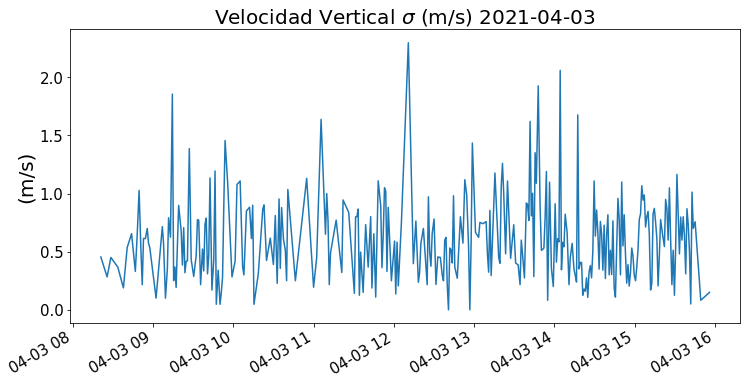

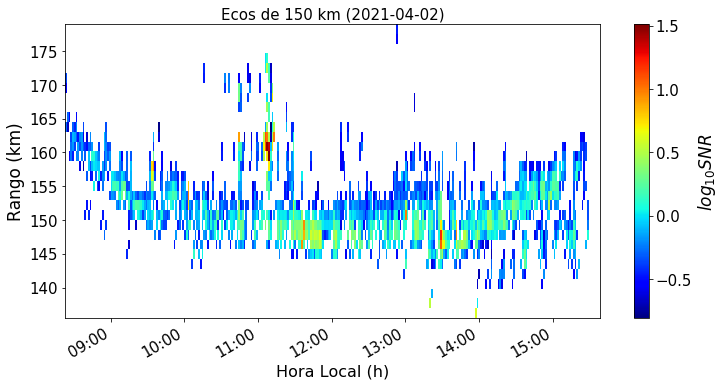

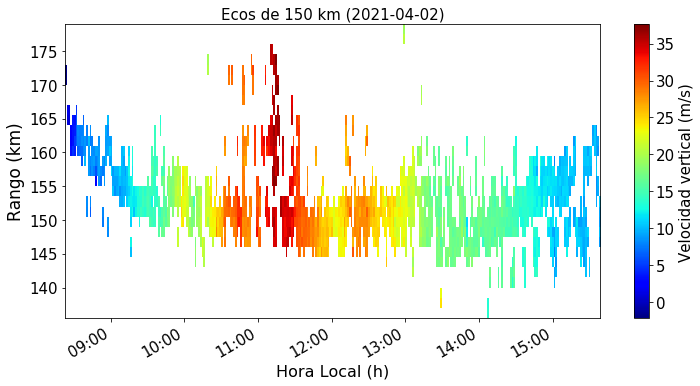

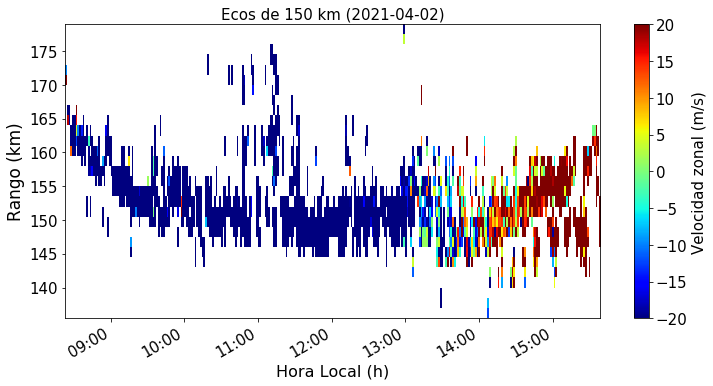

(30, 306) 2021-04-02 08:22:37 2021-04-02 15:38:39 0.0 135.45 178.95 1.5


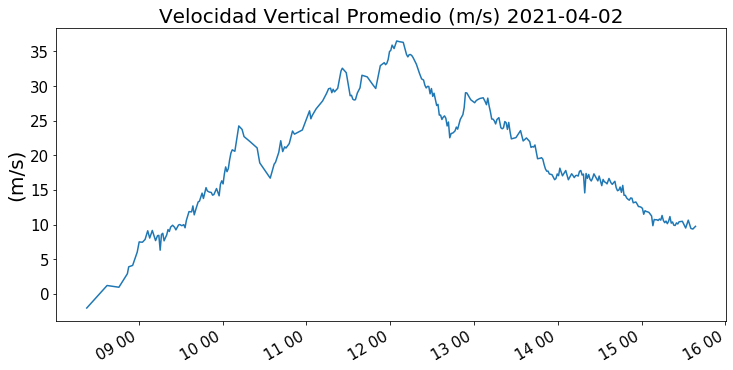

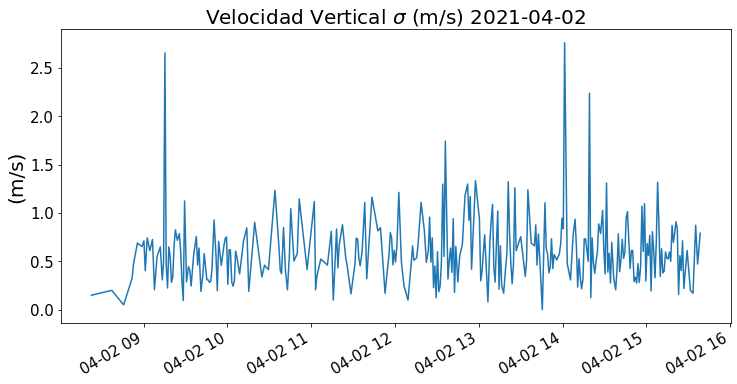

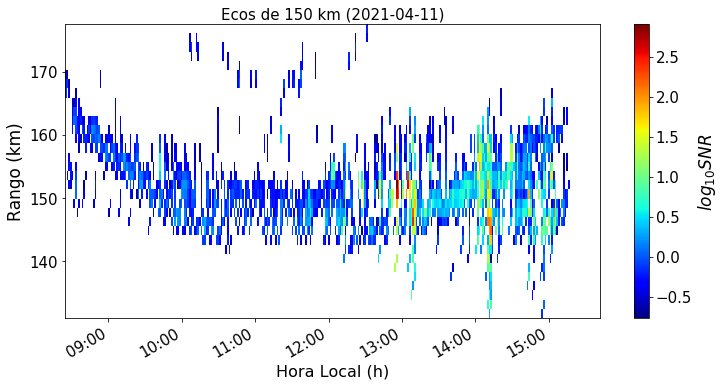

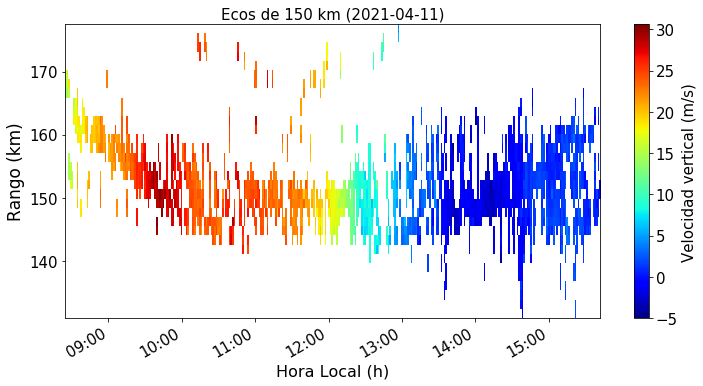

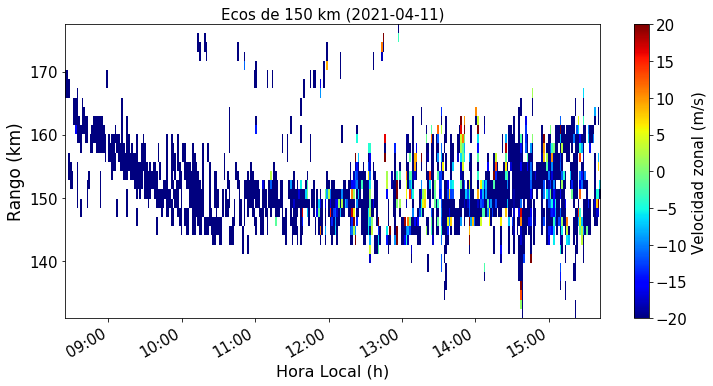

(32, 324) 2021-04-11 08:24:16 2021-04-11 15:42:09 0.0 130.95 177.45 1.5


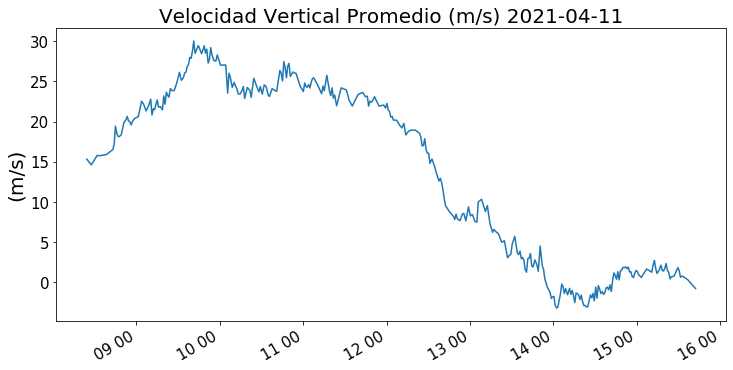

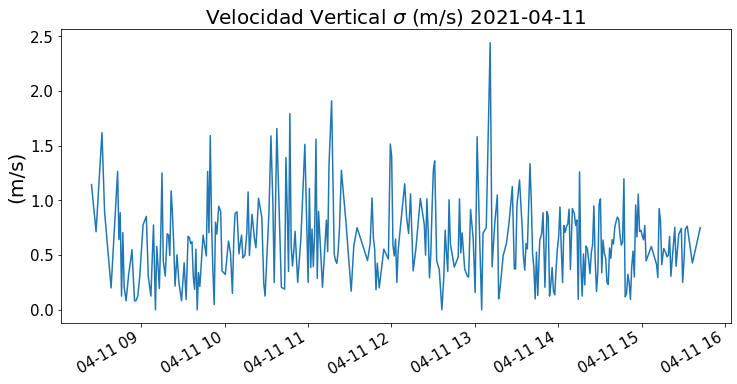

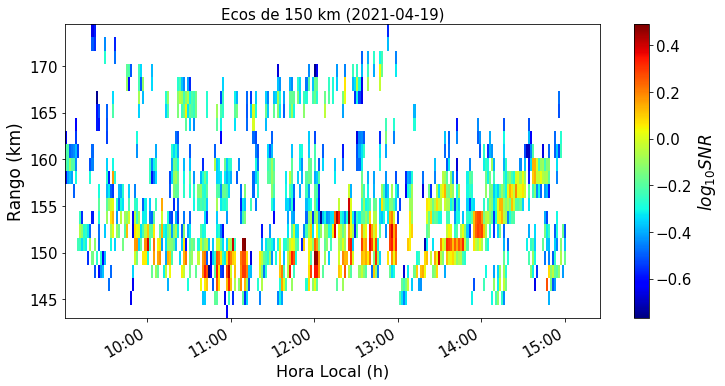

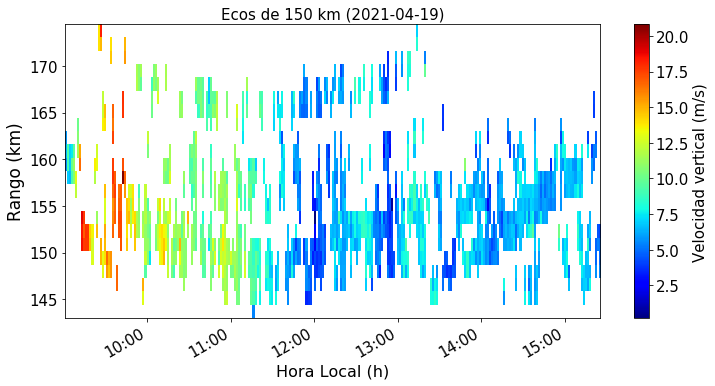

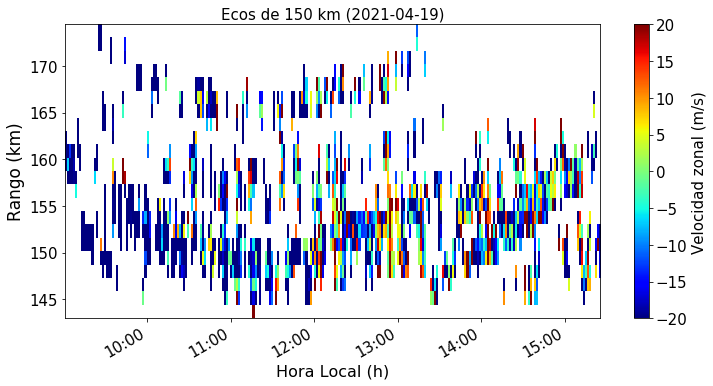

(22, 263) 2021-04-19 09:00:44 2021-04-19 15:25:36 0.0 142.95 174.45 1.5


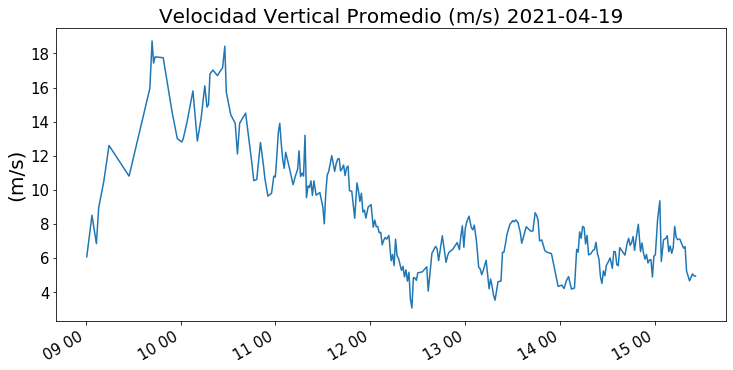

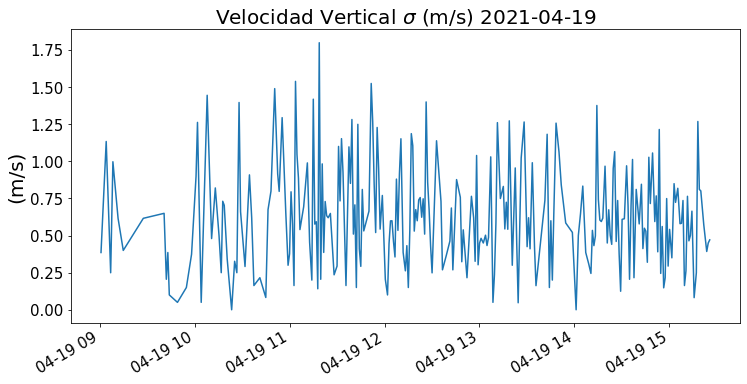

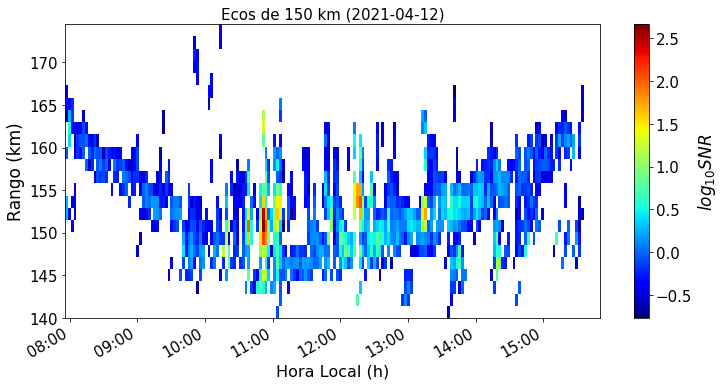

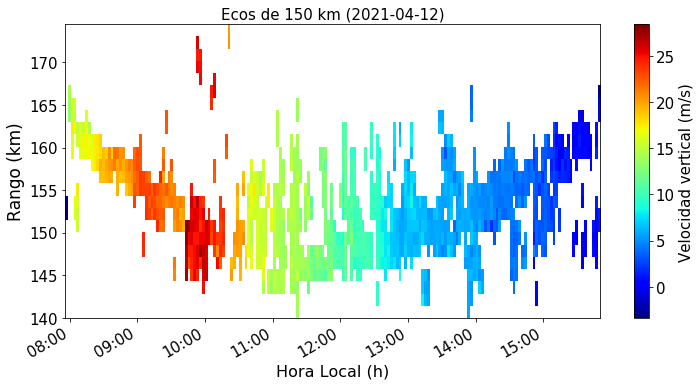

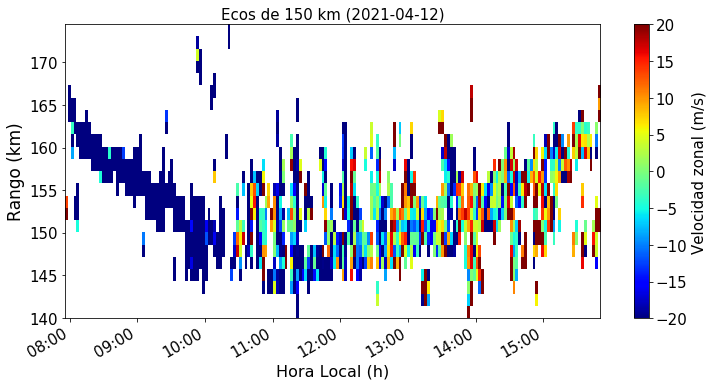

(24, 188) 2021-04-12 07:55:41 2021-04-12 15:50:39 0.0 139.95 174.45 1.5


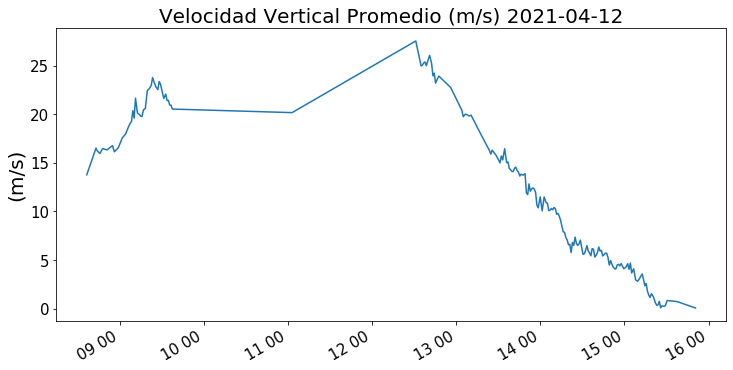

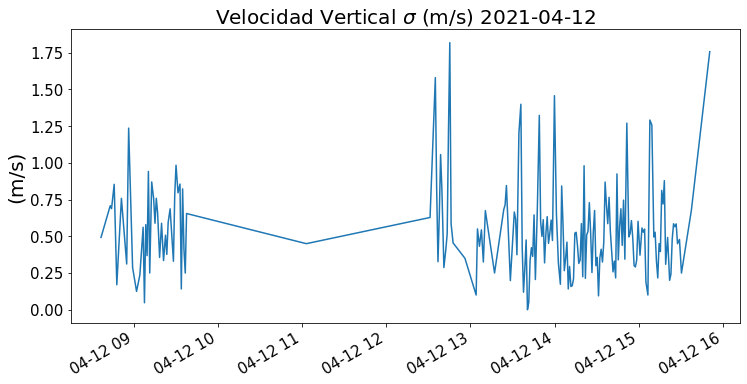

In [18]:
#'''
PlotFlag = True
#plot_format= 'png'
h_min = []
h_max = []
frames_avg = []
frames_std = []
num_stamps = []
t_h_min = []
t_h_max = []
for filename in os.listdir(directory):
    if filename.endswith(".hdf5"):
        #print(os.path.join(directory, filename))
        data ,snl, index, range_array, rango, dir_plots, time_vector, v_zonal, v_vertical, rango2D, timestamps, snl2 = GetMatrix_old(directory, filename, PlotFlag, plot_format)
        #print(data.shape, len(snl), index.shape, range_array.shape, len(rango))
        print(data.shape, index[0],index[-1], (index[1]-index[0]).total_seconds() ,range_array[0], range_array[-1], np.diff(range_array)[0]) 
        prev_times = [' ']
        k = 0
        for time in index:
            if prev_times[k] == time:
                   print('Same Time')
            else:
                #print 'Different time'
                if not time in prev_times:
                    prev_times.append(time)
                prev_time = time

        h_min.append(min(rango))
        h_max.append(max(rango))
    ###########################################################
        ran_max = max(rango)
        ran_min = min(rango)
        #rang_list = list(rango)
        max_index = rango.index(ran_max)
        min_index = rango.index(ran_min)
        t_h_min.append(index[min_index].to_pydatetime())
        t_h_max.append(index[max_index].to_pydatetime())
    ############################################################
        num_stamps.append(len(timestamps))
        prev_times = prev_times[1:]
        num_diff_times = len(prev_times)
        #print(num_diff_times)
        new_index = pd.DatetimeIndex(prev_times)
        index_ref = pd.DatetimeIndex(prev_times)
        if (new_index[0].hour <= 8):
            index_ref = new_index
        #v_vert_avg = np.nanmean(v_vertical,axis=1)
        #v_vert_std = np.nanstd(v_vertical,axis=1)
        #print("Vertical Average shape: ", v_vert_avg.shape, new_index.shape, new_index[0], new_index[-1])
        v_vert_avg = np.nanmean(v_vertical,axis=1)
        v_vert_std = np.nanstd(v_vertical,axis=1)
        df_std = pd.Series(v_vert_std, index=new_index)
        df = pd.Series(v_vert_avg, index=new_index)
        d = {'v_mean': v_vert_avg,'v_std': v_vert_avg,'time':new_index}
        pdf = pd.DataFrame(d)
        #df.set_index(index, inplace=True, drop=True)
        string_t0 = '%d-%02d-%02d %02d:%02d:00' % (new_index[0].year,new_index[0].month, new_index[0].day, 8,0)
        string_tf = '%d-%02d-%02d %02d:%02d:00' % (new_index[0].year,new_index[0].month, new_index[0].day, 17,0)
        
        if PlotFlag:
            fig, ax = plt.subplots(figsize=(12, 6))
            str_date = '%d-%02d-%02d' % (new_index[0].year,new_index[0].month,new_index[0].day)
            ax = df[string_t0:string_tf].plot()
            ax.set_ylabel('(m/s)', fontsize=20)
            ax.set_title('Velocidad Vertical Promedio (m/s) %s' % str_date, fontsize=20)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))
            plt.savefig('velocidad-vertical-promedio-%s.%s' % (str_date, str_format))
            plt.show()
            plt.close(fig)
            
            fig1, ax1 = plt.subplots(figsize=(12, 6))
        #str_date = '%d-%02d-%02d' % (new_index[0].year,new_index[0].month,new_index[0].day)
        #str_format = 'png'
        #v_vert_avg = np.nanmean(v_vertical,axis=1)
        #v_vert_std = np.nanstd(v_vertical,axis=1)
            #df_std = pd.Series(v_vert_std, index=new_index)
        #df = pd.Series(v_vert_avg, index=new_index)
        #df.set_index(index, inplace=True, drop=True)
            ax1 = df_std[string_t0:string_tf].plot()
            ax1.set_ylabel('(m/s)', fontsize=20)
            ax1.set_title(r'Velocidad Vertical $\sigma$ (m/s) %s' % str_date, fontsize=20)
        #ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))
            plt.savefig('velocidad-vertical-desviacion-estandar-%s.%s' % (str_date, str_format))
            plt.show()
            plt.close(fig)
        frames_avg.append(df)#[string_t0:string_tf])
        frames_std.append(df_std)#[string_t0:string_tf])
#'''

In [19]:
pdf.resample('H', on='time').v_mean.mean()


time
2021-04-12 07:00:00    -3.100000
2021-04-12 08:00:00    16.083148
2021-04-12 09:00:00    21.077911
2021-04-12 10:00:00          NaN
2021-04-12 11:00:00    20.166667
2021-04-12 12:00:00    24.768878
2021-04-12 13:00:00    14.850298
2021-04-12 14:00:00     6.856405
2021-04-12 15:00:00     2.023596
Freq: H, Name: v_mean, dtype: float64

Text(0.5, 1.0, 'Promedio 30 minutos - Derivas verticales-Ecos de 150 km (promedio mensual) 2020-04')

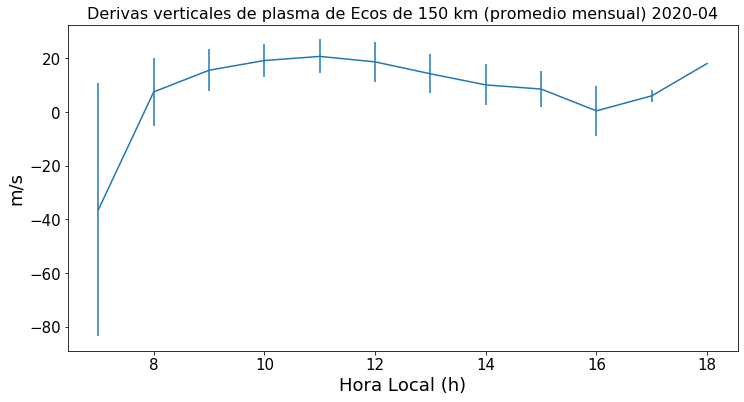

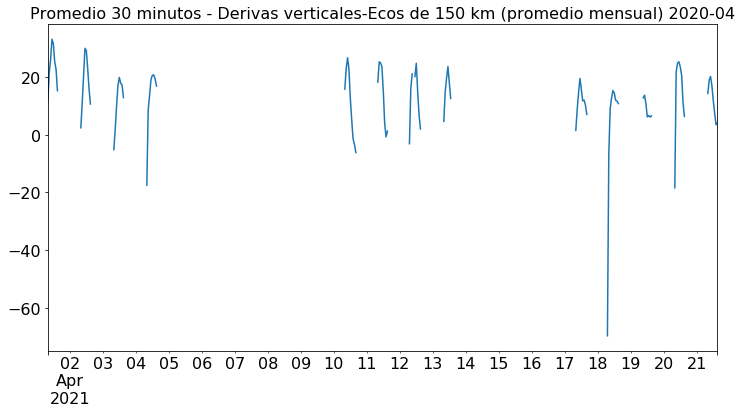

In [20]:
#new_index = series_avg.index
string_t0 = '%d-%02d-%02d %02d:%02d:00' % (index[0].year,index[0].month, index[0].day, 8,0)
string_tf = '%d-%02d-%02d %02d:%02d:00' % (index[0].year,index[0].month, index[0].day, 17,0)
series_avg = pd.concat(frames_avg)
series_std = pd.concat(frames_std)
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
#plt.style.use('seaborn-white')#'ggplot')#'classic')
axs = series_avg.groupby(series_avg.index.hour).mean().plot(yerr=series_avg.groupby(series_std.index.hour).std(),rot=0,ax=axs)
#groupby(pd.Grouper(series_avg.index,freq='30m')).
#axs = series_avg.groupby(pd.Grouper(freq='H')).mean().plot(yerr=series_avg.groupby(pd.Grouper(freq='H')).std(),rot=0,ax=axs)

fig_title = 'Derivas verticales de plasma de Ecos de 150 km (promedio mensual) 2020-%02d' % (index[0].month)
axs.set_title(fig_title, fontsize=16)
#axs.set_facecolor("white")
'''
str_ti = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,8)
str_tf = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,17)
dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
axs.set_xlim([dates.date2num(dti),dates.date2num(dtf)])
'''
#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs.set_xlabel('Hora Local (h)', fontsize=18)
axs.set_ylabel('m/s', fontsize=18)
#axs.set_xlim([100,400])

plt.savefig('promedio-mensual-drifts-%s.png' % current_month)
#'''
#series_avg.keys()
hh_avg = series_avg.groupby(pd.Grouper(freq='H')).mean()
#hh_std = series_avg[string_t0:string_tf].groupby(pd.Grouper(freq='H')).std()
fig1, axs1 = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
#plt.style.use('seaborn-white')#'ggplot')#'classic')
#axs1 = hh_avg.plot(yerr=hh_std,rot=0,ax=axs1)
axs1 = hh_avg.plot()
#axs1.set_xlim([7.5,17])
#axs1
#groupby(pd.Grouper(series_avg.index,freq='30m')).
#axs = series_avg.groupby(pd.Grouper(series_avg.index,freq='30m')).mean().plot(yerr=series_avg.groupby(pd.Grouper(series_avg.index,freq='30m')).std(),rot=0,ax=axs)

fig_title1 = 'Promedio 30 minutos - Derivas verticales-Ecos de 150 km (promedio mensual) 2020-%02d' % (index[0].month)
axs1.set_title(fig_title1, fontsize=16)

Text(0.5, 1.0, 'Promedio 30 minutos - Derivas verticales-Ecos de 150 km (promedio mensual) 2020-04')

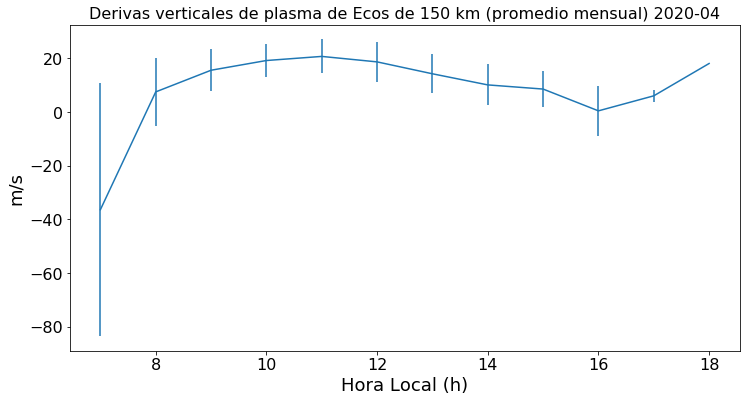

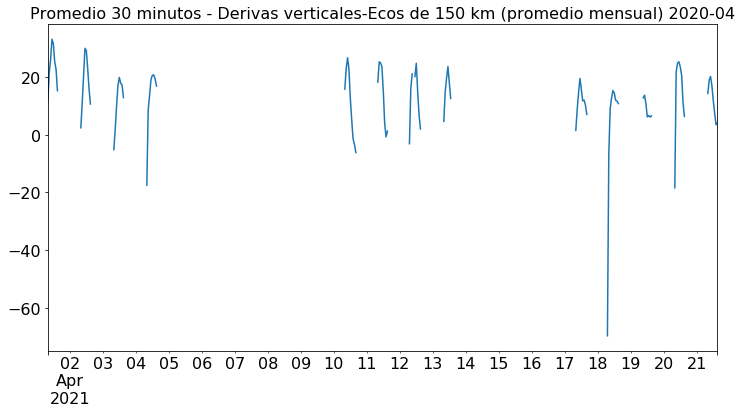

In [21]:
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
#plt.style.use('seaborn-white')#'ggplot')#'classic')
axs = series_avg.groupby(series_avg.index.hour).mean().plot(yerr=series_avg.groupby(series_std.index.hour).std(),rot=0,ax=axs)
#groupby(pd.Grouper(series_avg.index,freq='30m')).
#axs = series_avg.groupby(pd.Grouper(freq='H')).mean().plot(yerr=series_avg.groupby(pd.Grouper(freq='H')).std(),rot=0,ax=axs)

fig_title = 'Derivas verticales de plasma de Ecos de 150 km (promedio mensual) 2020-%02d' % (index[0].month)
axs.set_title(fig_title, fontsize=16)
#axs.set_facecolor("white")
'''
str_ti = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,8)
str_tf = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,17)
dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
axs.set_xlim([dates.date2num(dti),dates.date2num(dtf)])
'''
#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs.set_xlabel('Hora Local (h)', fontsize=18)
axs.set_ylabel('m/s', fontsize=18)
#axs.set_xlim([100,400])

plt.savefig('promedio-mensual-drifts-%s.png' % current_month)
#'''
#series_avg.keys()
hh_avg = series_avg.groupby(pd.Grouper(freq='H')).mean()
#hh_std = series_avg[string_t0:string_tf].groupby(pd.Grouper(freq='H')).std()
fig1, axs1 = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
#plt.style.use('seaborn-white')#'ggplot')#'classic')
#axs1 = hh_avg.plot(yerr=hh_std,rot=0,ax=axs1)
axs1 = hh_avg.plot()
#axs1.set_xlim([7.5,17])
#axs1
#groupby(pd.Grouper(series_avg.index,freq='30m')).
#axs = series_avg.groupby(pd.Grouper(series_avg.index,freq='30m')).mean().plot(yerr=series_avg.groupby(pd.Grouper(series_avg.index,freq='30m')).std(),rot=0,ax=axs)

fig_title1 = 'Promedio 30 minutos - Derivas verticales-Ecos de 150 km (promedio mensual) 2020-%02d' % (index[0].month)
axs1.set_title(fig_title1, fontsize=16)

<class 'numpy.ndarray'>
7
8
9
10
11
12
13
14
15
16
17
18
2021-04-12 07:00:00 2021-04-12 18:00:00
[datetime.datetime(2021, 4, 12, 7, 0) datetime.datetime(2021, 4, 12, 8, 0)
 datetime.datetime(2021, 4, 12, 9, 0)
 datetime.datetime(2021, 4, 12, 10, 0)
 datetime.datetime(2021, 4, 12, 11, 0)
 datetime.datetime(2021, 4, 12, 12, 0)
 datetime.datetime(2021, 4, 12, 13, 0)
 datetime.datetime(2021, 4, 12, 14, 0)
 datetime.datetime(2021, 4, 12, 15, 0)
 datetime.datetime(2021, 4, 12, 16, 0)
 datetime.datetime(2021, 4, 12, 17, 0)
 datetime.datetime(2021, 4, 12, 18, 0)]


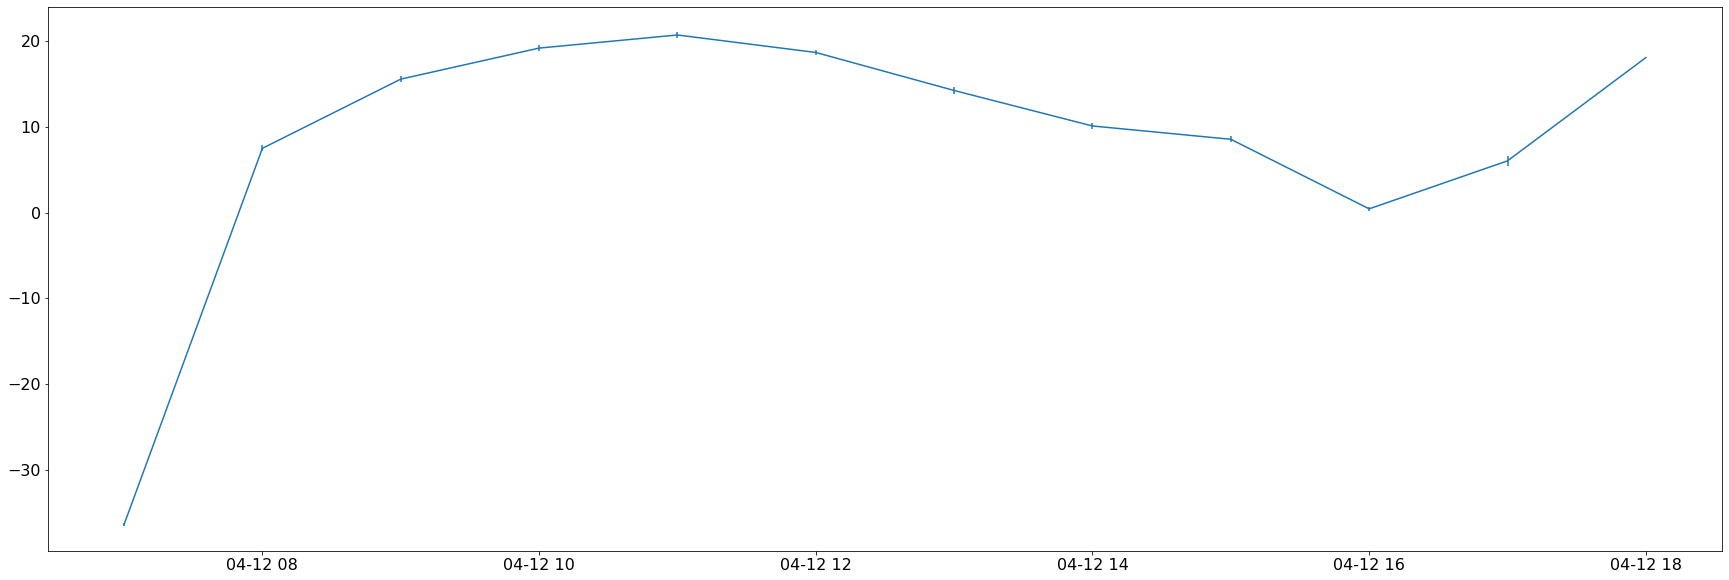

In [22]:
#series_avg.groupby(series_avg.index.hour).std()
#dt_array
#DriftMatrix[row,col] = vvert[k]#
list_std = series_std.groupby(series_std.index.hour).std()
list_avg = series_avg.groupby(series_avg.index.hour).mean()
dataPyDatetime = list_avg.index.values
print(type(dataPyDatetime))
#print(dataPyDatetime)
#print(index)
#index2 = index + timedelta(hours=0.5)
#print(index2)
dt_objs = []
for dP in dataPyDatetime:
    print(dP)
    date_time_str = '%d-%02d-%02d %02d:%02d:00' % (year, month, index[0].day, dP,0)
    date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
    dt_objs.append(date_time_obj)#+timedelta(minutes=30))
date_time_str2 = '%d-%02d-%02d %02d:%02d:00' % (year, month, index[0].day,17,0)
date_time_obj2 = datetime.datetime.strptime(date_time_str2, '%Y-%m-%d %H:%M:%S')

dt_objs.append(date_time_obj2)
time_objects_avg = np.array(dt_objs)
time_objects_avg=time_objects_avg[:-1]
print(time_objects_avg[0],time_objects_avg[-1])
#print(dt_array[0],dt_array[-1])
print(time_objects_avg)
#print(list_avg)
#'''
fig, ax = plt.subplots(figsize=(30,10))
ax.errorbar(mdates.date2num(time_objects_avg), list_avg, yerr=list_std, label='both')
ax.xaxis_date()
#'''

/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/juanpablo/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


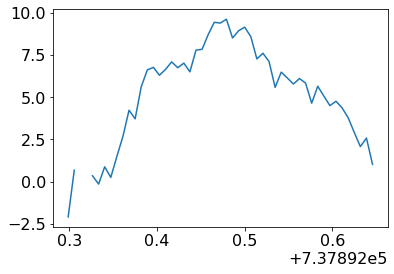

In [23]:
prom = np.nanmean(mat_drifts,axis=1)
std = np.nanstd(mat_drifts,axis=1)
plt.plot(mdates.date2num(time_range),prom)
#ax2.xaxis_date()


7    -36.375000
8      7.517527
9     15.587320
10    19.208317
11    20.737754
12    18.698789
13    14.263997
14    10.122493
15     8.572115
16     0.455000
17     6.052778
18    18.100000
dtype: float64
7     47.057956
8     12.644739
9      7.903482
10     6.106956
11     6.314831
12     7.565918
13     7.232888
14     7.663080
15     6.700054
16     9.340881
17     2.166800
18          NaN
dtype: float64
Abril-2021


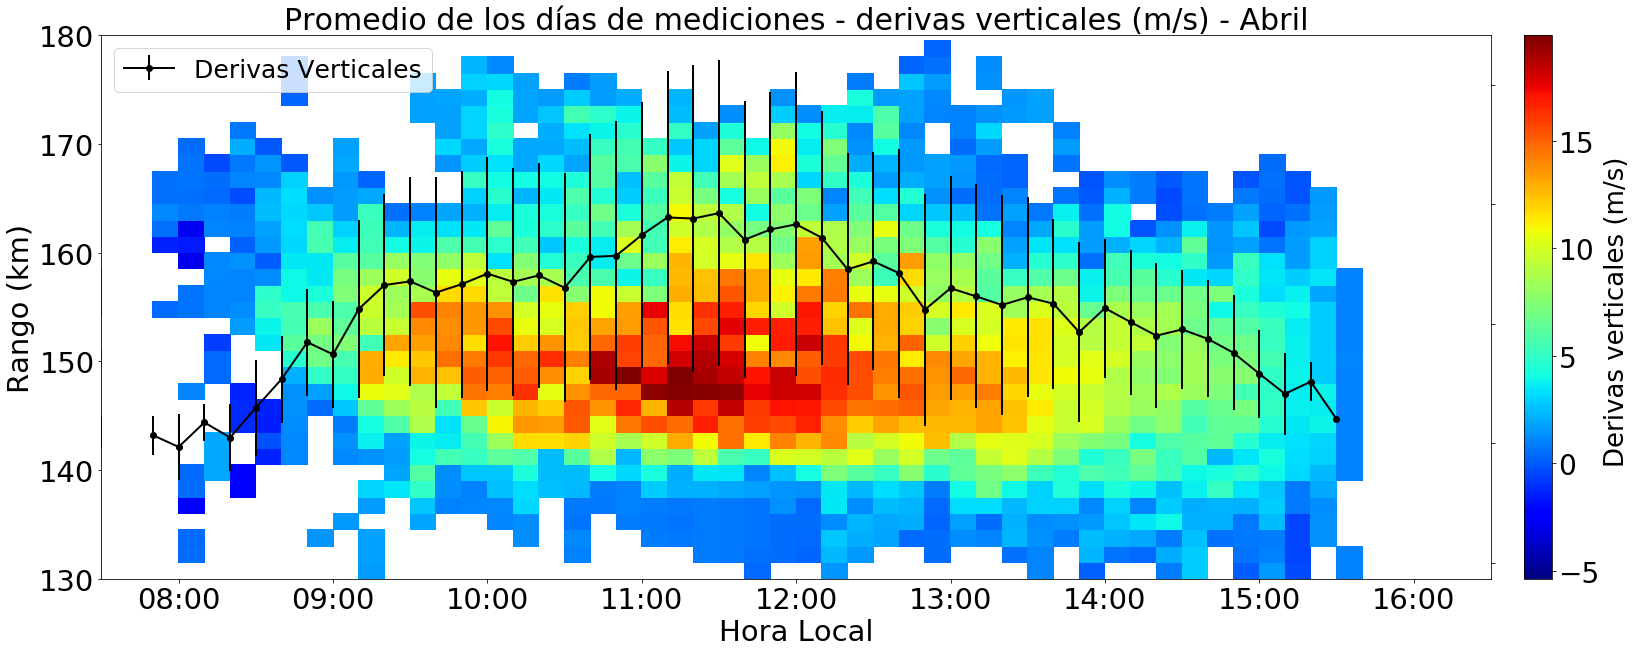

In [27]:
plot_format = 'png'
fig = plt.figure(figsize=(30,10))
plt.rcParams['ytick.labelsize']=29
plt.rcParams['xtick.labelsize']=29
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
plt.title("Promedio de los días de mediciones - derivas verticales (m/s) - %s" % GetMonth(month) ,fontsize=30)
#plt.style.use('white')
#print(dt_array[-1])
#print(dt_array[-12])
#print(dt_array[-66:-46])
#print(np.nanmean(avgMat[20:28,-66:-46],axis=0))
#print(range_array)
#ax.plt= ax.pcolormesh(dt_array, range_array, avgMat, cmap=plt.cm.RdBu_r)
color_palette='jet'#'seismic'#'seismic_r'#'jet'#'RdBu_r'#'plasma'
ax.plt=ax.pcolormesh(mdates.date2num(time_range), range_fixed, mat_drifts.T,cmap=color_palette)#'RdBu_r')#'jet')

#ax.plt= ax.pcolormesh(dt_array, range_array, avgMat, cmap=plt.cm.RdBu_r)

color='red'
#color='white'
ax.set_xlabel('Hora Local',fontsize=29)
ax.set_ylabel('Rango (km)',fontsize=29)
#ax.set_ylim(300, 400)
#ax.set_ylim(250, 500)
#ax.set_xlim([mdates.date2num(dt_array[ind_i]),mdates.date2num(dt_array[ind_f])])
str_ti = '%d-%02d-%02d %02d:%02d:00' % (year,month,time_range[0].day,7,30)
str_tf = '%d-%02d-%02d %02d:%02d:00' % (year,month,time_range[0].day,16,30)

dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])

ax.set_ylim(130, 180)
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
color_aux='white'
width_aux=6

cbar=fig.colorbar(ax.plt,ax=ax,pad=0.02)
cbar.set_label(r'Derivas verticales (m/s) ', fontsize=26)
cbar.ax.tick_params(labelsize=28)

list_avg = series_avg.groupby(series_avg.index.hour).mean()
list_std = series_avg.groupby(series_std.index.hour).std()
print(list_avg)
print(list_std)
#list_avg.plot(yerr=list_std,label='Derivas Verticales', marker='o',color='black',lw=8)
#ax2.plt = ax2.plot(mdates.date2num(time_range),prom,marker='o',color='black',lw=8)
ax2.plt = ax2.errorbar(mdates.date2num(time_range), prom, yerr=std, label='Derivas Verticales',marker='o',color='black',lw=2)
ax2.xaxis_date()
#print(prom)
#ax2.errorbar(mdates.date2num(time_objects_avg), list_avg, yerr=list_std, label='Derivas Verticales',marker='o',color='black',lw=8)
plt.legend(loc="upper left",prop={'size':25})
ax2.axes.yaxis.set_ticklabels([])
nan_series={}
ax2.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_xlim([dates.date2num(dti),dates.date2num(dtf)])

#ax2.set_ylim([-30,30])
#ax2.set_xlim([7.5,16.5])#7.5,19.5

plt.setp( ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )

#ax2.set_ylim([-15,20])
#ax2.set_xlim([7.5,17.5])#7.5,19.5
#ax2.set_xlim([6,18])
cbar2=fig.colorbar(ax.plt,ax=ax2,pad=0.02)
#cbar2.mappable.set_clim(-30,30)

cbar2.remove()
print(current_month)
plt.savefig('%s-RTI-promedio-vs-promedio-derivas-verticales-ecos-de-150km-%s.%s' % (color_palette,current_month,plot_format),dpi=500,bbox_inches="tight")
plt.show()

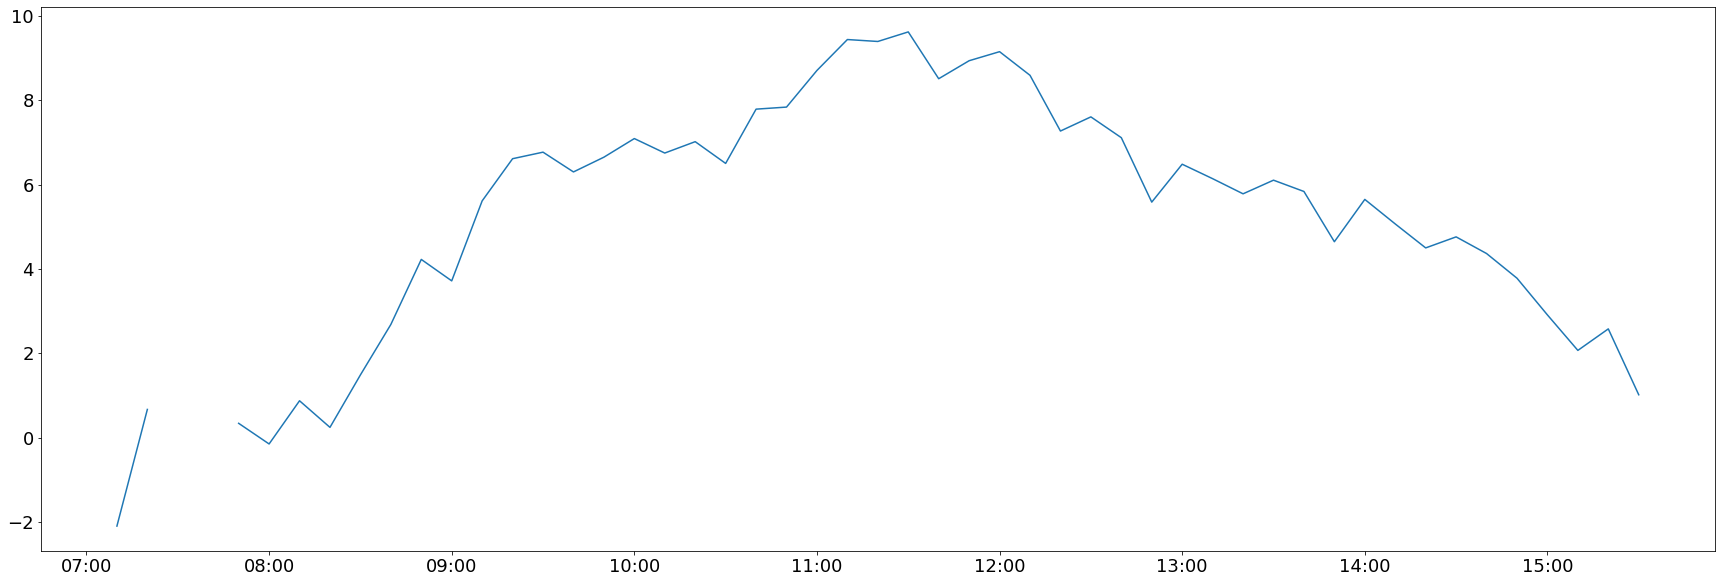

In [25]:
fig = plt.figure(figsize=(30,10))
ax1=fig.add_subplot(111, label="1")

ax1.plt = ax1.plot(mdates.date2num(time_range),prom)
ax1.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(date_format)
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
#plt.show()

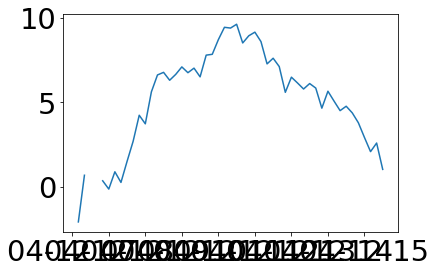

In [26]:
plt.plot(time_range,prom)
#plt.xaxis_date()
